In [128]:
logex = np.array([8.69,8.06,7.55,7.51,7.12,6.30])
xmass = np.array([15.999,20.1797,24.305,28.085,32.06,40.078])/1.008
zx = 0.0187
a = np.sum(np.multiply(10**(logex-12.0),xmass/zx))
print(a)
b = 1-a
print(b)

0.6592552020258998
0.3407447979741002


In [117]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
    def __init__(self,teff,abund,obsphot,distance,isochrones,rv=3.1):
        
        '''
        teff: [array] Teff and error of star np.array([teff,teff_err])
        abund: [2x1 array] first column is [M/H],[Alpha/M]
        obs_phot: [5x2 array] first column is GBP,GRP,J,H,K and the second column is the errors in the first 
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        rv: [float] Rv value (=Av/E(B_V)) 
        '''
        
        # Observed Quantities
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
#         # Asplund 2009 
#         self.salfeh = abund[0,0]+np.log10(0.655*(10**(abund[1,0]))+0.345) # Salaris Corrected [Fe/H]
#         self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.345/(0.655*(10**(abund[1,0]))+0.345))*abund[1,1])**2)
        # Asplund 2021 et al.
        self.salfeh = abund[0,0]+np.log10(0.659*(10**(abund[1,0]))+0.341) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.341/(0.659*(10**(abund[1,0]))+0.341))*abund[1,1])**2)
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
#         self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def mad(self,data):
        '''
        Calculate the median absolute deviation of the data
        '''
        return np.nanmedian(np.abs(data-np.nanmedian(data)))
    
    ##################
    ### Extinction ###
    ##################
    
    def ccm_a(self,x):
        '''
        a(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def ccm_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/self.rv
        return alav
    
    def extinction(self):
        '''
        Calculate the K band extinction and its uncertainty
        '''

        ### Reddening to K band extinctions based on Cardelli et al.
        ebpk_k = ((self.ccm_alav(self.leff['G_BPmag'])-self.ccm_alav(self.leff['Ksmag']))/
                  self.ccm_alav(self.leff['Ksmag']))
        erpk_k = ((self.ccm_alav(self.leff['G_RPmag'])-self.ccm_alav(self.leff['Ksmag']))/
                  self.ccm_alav(self.leff['Ksmag']))
        ejk_k = ((self.ccm_alav(self.leff['Jmag'])-self.ccm_alav(self.leff['Ksmag']))/
                 self.ccm_alav(self.leff['Ksmag']))
        ehk_k = ((self.ccm_alav(self.leff['Hmag'])-self.ccm_alav(self.leff['Ksmag']))/
                 self.ccm_alav(self.leff['Ksmag']))

        e_k = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

        ### Spline 
        # pick isochrone points with temperatures within 100 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+100.))&
                           (self.iso['logTe']>np.log10(self.teff-100.)))
        iso_ = self.iso[teffcut]

        # sort teffs
        sidx = np.argsort(iso_['logTe'])
        slogTe = iso_['logTe'][sidx]
        _, uidx = np.unique(slogTe,return_index=True)
        slogTe = slogTe[uidx]

        calc_aks = 999999.0*np.ones(4)
        calc_aks_err = 999999.0*np.ones(4)

        coeff0s = 999999.0*np.ones(4)
        for i in range(4):
            try:
                coeff = np.polyfit(10**slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx],1)
                color_line = np.poly1d(coeff)
                calc_aks[i] = np.divide((self.phot[i]-self.phot[-1])-color_line(self.teff),e_k[i])
                coeff0s[i] = coeff[0]

            except:
                calc_aks[i] = 999999.0 
                calc_aks_err[i] = 999999.0

        calc_aks_err = np.sqrt(np.divide(np.square(self.phot_err[:-1])+
                                         np.square(np.multiply(coeff0s,self.teff_err)),np.square(e_k)))

        ### Weighted Mean
        wgts = np.square(np.reciprocal(calc_aks_err))
        wgts_sum = np.sum(wgts)

        ak = np.sum(np.multiply(calc_aks,wgts))/wgts_sum
        ak_err = np.sqrt(np.reciprocal(wgts_sum))
        
        self.ak = ak
        self.ak_err = ak_err
        
        return ak, ak_err
    
    def ak_calib(self):
        '''
        Ak calibration based on comparing the raw calculated APOKASC Ak value and KIC converted Ak
        '''
        x = self.ak
        ak0 = 0.12500
        a = -1.85323
        b = -0.32056
        c = 0.03917
        d = -0.91372
        e = -0.45103
        f = 0.06226
        
        self.ak_calib = np.piecewise(x,[x<ak0],[lambda x: a*x**2+b*x+c, lambda x: d*x**2+e*x+f])
        self.ak_calib_err = np.piecewise(x,[x<ak0],[lambda x: a*x+b, lambda x: d*x+e])*self.ak_err
    
    #################################
    ### Magnitudes, Ages & Masses ###
    #################################
    
#     def teff_2_appmags(self,teff,age):
#         '''
#         Calculate the expected apparent magnitudes of a star in the BP, RP, J, H, and K bands
        
#         Input:
#         -----
#             teff: Teff of a star
#             age: age of a star
            
#         Output:
#         ------
#             calc_mags: calculated absolute magnitude
#         '''
        
#         ### Setup Calculations
#         # extinctions
#         abpak = (self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag']))
#         arpak = (self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag']))
#         ajak = (self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag']))
#         ahak = (self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag']))
        
#         aks = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak
        
#         # log values
#         lgteff = np.log10(teff)
#         lgage = np.log10(age*10**9)
        
#         ### Check if age is in table
#         if lgage in self.uniq_ages:
            
#             # pick isochrone and only keep points close in Teff 
#             aidx, = np.where(self.uniq_ages==lgage)
#             iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
#             iso_ = iso_[np.where((iso_['logTe']<np.log10(teff+100.))&(iso_['logTe']>np.log10(teff-100.)))]
            
#             # check if there are enough points
#             if np.size(iso_) < 2:
#                 return np.array([999999.0,999999.0,999999.0,999999.0,999999.0])
            
#             # sort Teff values
#             sidx = np.argsort(iso_['logTe'])
#             slogTe = iso_['logTe'][sidx]
#             _, uidx = np.unique(slogTe,return_index=True)
#             slogTe = slogTe[uidx]
            
#             # calculate the apparent magnitudes
#             calc_mags = 999999.0*np.ones(5)
#             for i in range(len(calc_mags)):
#                 interpol = np.poly1d(np.polyfit(slogTe,iso_[self.labels[i]][sidx][uidx],1))
#                 calc_mags[i] = interpol(teff)+self.distmod+aks[i]
                
#             return calc_mags
            
#         else:
#             # find closest two ages to the given age
#             lgage_lo, lgage_hi = self.neighbors(self.uniq_ages,lgage)
            
#             # lower age
#             # pick isochrone and only keep points close in Teff
#             aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#             iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
#             iso_lo = iso_lo[np.where((iso_lo['logTe']<np.log10(teff+100.))&
#                                      (iso_lo['logTe']>np.log10(teff-100.)))]
            
#             # sort Teff values
#             sidx_lo = np.argsort(iso_lo['logTe'])
#             slogTe_lo = iso_lo['logTe'][sidx_lo]
#             _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#             slogTe_lo = slogTe_lo[uidx_lo]
            
#             # higher age
#             # pick isochrone and only keep points close in Teff
#             aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#             iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
#             iso_hi = iso_hi[np.where((iso_hi['logTe']<np.log10(teff+100.))&
#                                      (iso_hi['logTe']>np.log10(teff-100.)))]
            
#             # check if there are enough points
#             if (np.size(iso_lo) < 2) or (np.size(iso_hi) < 2):
#                 return np.array([999999.0,999999.0,999999.0,999999.0,999999.0])
            
#             # sort Teff values
#             sidx_hi = np.argsort(iso_hi['logTe'])
#             slogTe_hi = iso_hi['logTe'][sidx_hi]
#             _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#             slogTe_hi = slogTe_hi[uidx_hi]
            
#             # calculate the apparent magnitudes
#             calc_mags = 999999.0*np.ones(5)
#             for i in range(len(calc_mags)):
#                 interpol_lo = np.poly1d(np.polyfit(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo],1))
#                 interpol_hi = np.poly1d(np.polyfit(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi],1))
#                 interpol_age = np.poly1d(np.polyfit([lgage_lo,lgage_hi],
#                                                     [interpol_lo(teff),interpol_hi(teff)],1))
#                 calc_mags[i] = interpol_age(lgage)+self.distmod+aks[i]
        
#             return calc_mags
        
    def teff_2_appmags(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak
        
        lgage = np.log10(age*10**9)
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]

            return calc_mags
        
#     def get_age(self):
#         '''
#         Calculate the age of a star
#         '''
#         guess_ages = np.linspace(0.,17.)[::3]
        
#         for i in range(len(guess_ages)):
            
#             ages = 
#             try:
                
#             except:
#                 calc_age = 999999.0
        
#         return calc_age
        
    def get_age(self,guess_ages=np.linspace(0.,17.)[::3],verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr

            
        Output:
        ------
            
        '''
            
        # initialize lists
        
        curve_ages = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)): 
            try:
                # calculate best fit parameters and covariance matrix
                popt,pcov = curve_fit(self.teff_2_appmags,self.teff,self.phot,p0=guess_ages[j],
                                      bounds=(0.,17.),method='trf',sigma=self.phot_err,
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
                curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0]))
                curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

            except:
                #populate lists
                curve_ages.append(999999.0)
                curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        age = np.asarray(curve_ages)[idx]
        self.age = age

#         best_params = np.array([age,age_err])
#         best_params_err = np.array([age_err,ak_err])
#         best_mags = self.teff_2_appmags_age(self.teff,age)#,ak)

#         if verbose:
#             print('Best Fit Params [Age, Age Err]:',np.round(best_params,3))
#             print('Best Apparent Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
#             print('Obs Apparent Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
#             print('Obs Apparent Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return age
    
    def get_mass(self):
        '''
        Calculate the mass of a star by interpolating isochrones with already calculated Ak and age 

        Output:
        ------
        mass: mass of star in solar masses
        mass_err: error in the calculated mass of the star
        '''

        if self.age == 999999.0:
            return 999999.0 #np.array([999999.0,999999.0])
        
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+100.))&
                           (self.iso['logTe']>np.log10(self.teff-100.)))
        iso_ = self.iso[teffcut]
        
        if np.size(iso_) < 2:
            return 999999.0
        
        ### calculate the mass using interpolation
        coeffs = np.polyfit(iso_['logAge'],iso_['Mass'],4)
        interpol = np.poly1d(coeffs)
        mass = interpol(np.log10(self.age*10**9))
        self.mass = mass
        
        ### get error in mass calculation
#         deriv = np.poly1d(np.multiply(coeffs[:-1],np.arange(len(coeffs))[::-1][:-1]))
#         mass_err = np.abs(deriv(np.log10(self.age*10**9)))*self.age_err
#         self.mass_err = mass_err
        
        return mass#, mass_err
    
#     def age_diagnostic(self,best_fit_age,star_name=None,lit_age=None,filename=None,verbose=False):
#         '''
#         Create a diagnostic plot for the best fit age
        
#         Inputs:
#         ------
#             best_fit_age: best fit age in Gyr
#             star_name: name of star
#             lit_age: known literature age in Gyr
#             filename: name of file if saving plot
#         '''
        
#         # intialize arrays
#         ages = np.arange(0,15,0.25)
#         theos_w_ext = 999999.0*np.ones((len(ages),5))
#         theos_wo_ext = 999999.0*np.ones((len(ages),5))
        
#         # Calculate theoretical mags given an age in ages
#         for i in range(len(ages)):
#             theos_w_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],self.ak)
#             theos_wo_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],0)
            
#         # plot results
#         fig, ax = plt.subplots(1,5,figsize=[67,15])
#         for j in range(5):
#             # with extinction
#             ax[j].scatter(theos_w_ext[:,j],ages,s=100,label='Best Fit Ak')
#             ax[j].plot(theos_w_ext[:,j],ages)
            
#             # without extinction
#             ax[j].scatter(theos_wo_ext[:,j],ages,s=100,label='No Ak')
#             ax[j].plot(theos_wo_ext[:,j],ages)
            
#             ax[j].axhline(best_fit_age,c='r',ls='--',label='Best Fit Age',lw=3.0)
            
#             if lit_age != None:
#                 ax[j].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
                
#             ax[j].axvline(self.phot[j],ls='--',c='magenta',lw=3.0)
            
#             ax[j].set_xlim(-14,14)
#             ax[j].set_ylim(bottom=0.01)
            
#             ax[j].set_title(r'{}: {:.3f}'.format(self.labels[j],self.phot[j]))
#             ax[j].set_xlabel(r'Magnitude')
        
#         ax[0].legend()
        
#         ax[0].set_ylabel('Age')
        
#         if star_name != None:
#             plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_age,
#                                                                           self.ak,self.distance))
            
#         else:
#             plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_age,self.ak,
#                                                                       self.distance))
            
#         if filename != None:
#             plt.savefig(filename,bbox_inches='tight')
            
#         plt.show()
        
    def mass_2_age(self,mass):
        '''

        Input:
        -----
            mass: mass of star

        Output:
        ------
            age: age of star
        '''

        try:
            mass_lo,mass_hi = neighbors(self.iso['Mass'],mass)

            iso_lo = self.iso[np.where(self.iso['Mass']==mass_lo)]
            iso_hi = self.iso[np.where(self.iso['Mass']==mass_hi)]

            # younger
            sidx_lo = np.argsort(iso_lo['MH'])
            sMH_lo = iso_lo['MH'][sidx_lo]
            _, uidx_lo = np.unique(sMH_lo,return_index=True)
            sMH_lo = sMH_lo[uidx_lo]

            spl_lo = interp1d(sMH_lo,10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9)

            # older
            sidx_hi = np.argsort(iso_hi['MH'])
            sMH_hi = iso_hi['MH'][sidx_hi]
            _, uidx_hi = np.unique(sMH_hi,return_index=True)
            sMH_hi = sMH_hi[uidx_hi]

            spl_hi = interp1d(sMH_hi,10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9)

            # final spline
            final_spl = interp1d([mass_lo,mass_hi],[spl_lo(self.salfeh),spl_hi(self.salfeh)])
            age = final_spl(mass)
            return age
        except:
            return 999999.0
        
    def mass_2_age_PARSEC(self,mass,parsec):
        '''
        Input:
        -----
            mass: mass of star

        Output:
        ------
            age: age of star
        '''

        try:
            mass_lo,mass_hi = self.neighbors(self.iso['Mass'],mass)

            iso_lo = self.iso[np.where(self.iso['Mass']==mass_lo)]
            iso_hi = self.iso[np.where(self.iso['Mass']==mass_hi)]

            # younger
            sidx_lo = np.argsort(iso_lo['MH'])
            sMH_lo = iso_lo['MH'][sidx_lo]
            _, uidx_lo = np.unique(sMH_lo,return_index=True)
            sMH_lo = sMH_lo[uidx_lo]

            spl_lo = interp1d(sMH_lo,10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9)

            # older
            sidx_hi = np.argsort(iso_hi['MH'])
            sMH_hi = iso_hi['MH'][sidx_hi]
            _, uidx_hi = np.unique(sMH_hi,return_index=True)
            sMH_hi = sMH_hi[uidx_hi]

            spl_hi = interp1d(sMH_hi,10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9)

            # final spline
            final_spl = interp1d([mass_lo,mass_hi],[spl_lo(self.salfeh),spl_hi(self.salfeh)])
            age = final_spl(mass)
            return age
        except:
            return 999999.0
        
    def mass_2_age_MESA(self,star_mass,mesa):
        '''

        Input:
        -----
            star_mass: star_mass of star

        Output:
        ------
            age: age of star
        '''

        try:
            star_mass_lo,star_mass_hi = self.neighbors(mesa['star_mass'],star_mass)

            iso_lo = mesa[np.where(mesa['star_mass']==star_mass_lo)]
            iso_hi = mesa[np.where(mesa['star_mass']==star_mass_hi)]

            # younger
            sidx_lo = np.argsort(iso_lo['MH'])
            sMH_lo = iso_lo['MH'][sidx_lo]
            _, uidx_lo = np.unique(sMH_lo,return_index=True)
            sMH_lo = sMH_lo[uidx_lo]

            spl_lo = interp1d(sMH_lo,10**iso_lo['log10_isochrone_age_yr'][sidx_lo][uidx_lo]/10**9)

            # older
            sidx_hi = np.argsort(iso_hi['MH'])
            sMH_hi = iso_hi['MH'][sidx_hi]
            _, uidx_hi = np.unique(sMH_hi,return_index=True)
            sMH_hi = sMH_hi[uidx_hi]

            spl_hi = interp1d(sMH_hi,10**iso_hi['log10_isochrone_age_yr'][sidx_hi][uidx_hi]/10**9)

            # final spline
            final_spl = interp1d([star_mass_lo,star_mass_hi],[spl_lo(self.salfeh),spl_hi(self.salfeh)])
            age = final_spl(star_mass)
            return age
        except:
            return 999999.0

# Extra Functions

In [3]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

In [4]:
from scipy.optimize import curve_fit

# PARSEC

In [5]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# APOKASC

<ipython-input-6-ea4b86b12b0d>:28: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


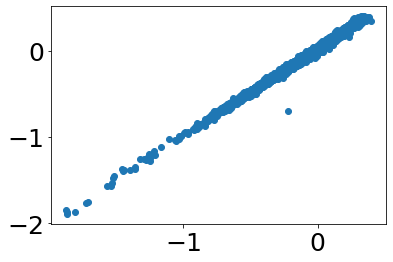

In [6]:
from astropy.io import ascii

kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')

# xmatch APOKASC Catalogs
_, k672idx, k3idx = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)
k672 = kasc672[k672idx]
k3 = kasc3[k3idx]

# xmatch APOKASC with DR17
_, k3idx, dr17idx = np.intersect1d(k3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

k672dr17 = k672[k3idx]
k3dr17 = k3[k3idx]
kdr17 = dr17[dr17idx]

# Select RGB stars
ageevs = np.where((k3dr17['IntAge']>-10.)&(k672dr17['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kdr17['GAIAEDR3_PARALLAX']/kdr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

k672dr17 = k672dr17[ageevs]
k3dr17 = k3dr17[ageevs]
kdr17 = kdr17[ageevs]

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

plt.scatter(kdr17['FE_H'],k3dr17['Fe/H'])

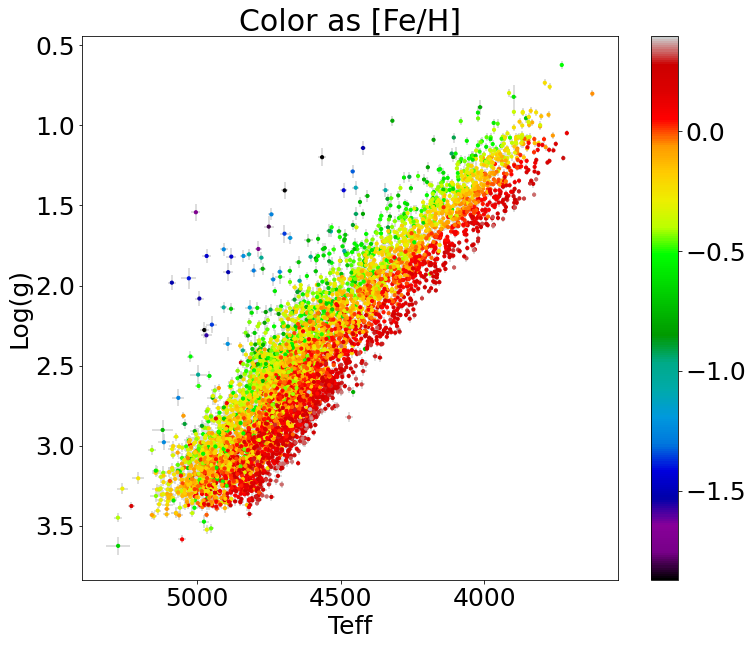

In [7]:
plt.figure(figsize=[12,10])
plt.scatter(kdr17['TEFF'],kdr17['LOGG'],c=kdr17['FE_H'],
            cmap='nipy_spectral',s=10)
cbar = plt.colorbar()
plt.errorbar(kdr17['TEFF'],kdr17['LOGG'],xerr=kdr17['TEFF_ERR'],
             yerr=kdr17['LOGG_ERR'],ls=' ',c='lightgrey',zorder=0)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

# plt.savefig(r'../plots/apokascHRA.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Gaia Magnitude Errors

In [8]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

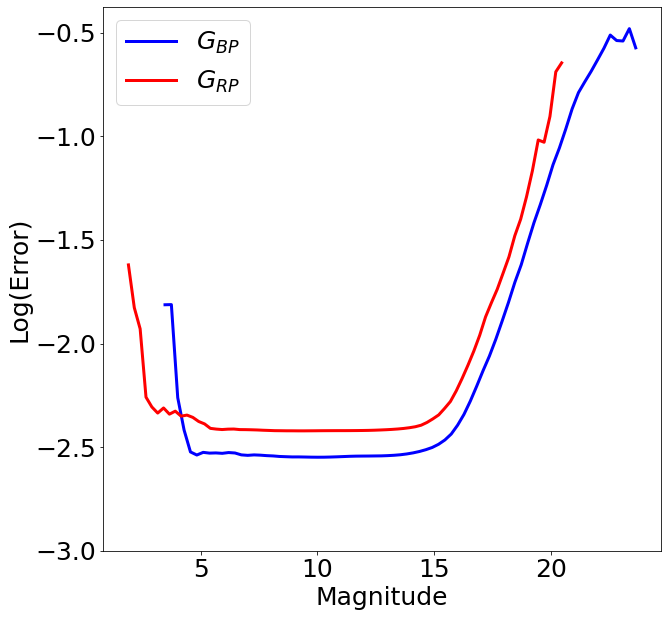

In [9]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

# Calculate Extinctions, Ages, and Masses

In [10]:
from tqdm import tqdm_notebook

In [11]:
apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = kdr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(kdr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

<ipython-input-11-764cca630a24>:2: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


In [12]:
kasc_ak = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_ak_calib = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_age = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_mass = 999999.0*np.ones(len(np.squeeze(ageevs)))

for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):
    te = np.array([kdr17['TEFF'][i],kdr17['TEFF_ERR'][i]])
    ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
                   [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    kdr17['J'][i],kdr17['H'][i],
                    kdr17['K'][i]],
                   [bperr[i],rperr[i],kdr17['J_ERR'][i],
                    kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
    di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcAge = Aetas(te,ab,op,di,massive,rv=3.1)
    CalcAge.extinction()
    CalcAge.ak_calib()
    kasc_ak[i] = CalcAge.ak
    kasc_ak_calib[i] = CalcAge.ak_calib
    
    
    age_val = CalcAge.get_age()
    kasc_age[i] = age_val
    
    mass_val = CalcAge.get_mass()
    kasc_mass[i] = mass_val

<ipython-input-12-31a7aacd5b60>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):


In [13]:
from scipy.stats import binned_statistic, binned_statistic_2d

## PARSEC Reference Ages

In [14]:
def mass_2_age_PARSEC(mass,salfeh,isochrones):
    '''
    Inputs:
    ------
        mass: star mass in Msun
        salfeh: Salaris corrected [Fe/H]
        isochrones: table of PARSEC isochrones
    
    Output:
    ------
        age: age in Gyr
    '''
    
    feh_lo,feh_hi = neighbors(isochrones['MH'],salfeh)
    
    iso_lo = isochrones[np.where(isochrones['MH']==feh_lo)]
    iso_hi = isochrones[np.where(isochrones['MH']==feh_hi)]
    
    try:
        # lower [Fe/H]
        sidx_lo = np.argsort(iso_lo['Mass'])
        smass_lo = iso_lo['Mass'][sidx_lo]
        _,uidx_lo = np.unique(smass_lo,return_index=True)
        smass_lo = smass_lo[uidx_lo]
        sage_lo = 10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9

        spl_lo = interp1d(smass_lo,sage_lo)

        # higher [Fe/H]
        sidx_hi = np.argsort(iso_hi['Mass'])
        smass_hi = iso_hi['Mass'][sidx_hi]
        _,uidx_hi = np.unique(smass_hi,return_index=True)
        smass_hi = smass_hi[uidx_hi]
        sage_hi = 10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9

        spl_hi = interp1d(smass_hi,sage_hi)

        # final spline
        final_spl = interp1d([feh_lo,feh_hi],[spl_lo(mass),spl_hi(mass)])
        age = final_spl(salfeh)
        return age
    except:
        return 999999.0

pkasc_age = 999999.0*np.ones(len(np.squeeze(ageevs)))

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):
    te = np.array([kdr17['TEFF'][i],kdr17['TEFF_ERR'][i]])
    ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
                   [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    kdr17['J'][i],kdr17['H'][i],
                    kdr17['K'][i]],
                   [bperr[i],rperr[i],kdr17['J_ERR'][i],
                    kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
    di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcAge = Aetas(te,ab,op,di,massive,rv=3.1)
    pkasc_age[i] = mass_2_age_PARSEC(k3dr17['Mass'][i],CalcAge.salfeh,massive)

<ipython-input-14-cda1cc875534>:48: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)
<ipython-input-14-cda1cc875534>:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):


In [15]:
# plt.hist(kasc_age,range=(0,20),histtype='step')
# plt.hist(pkasc_age,range=(0,20),histtype='step')
# plt.show()

In [16]:
pkasc_age

array([9.69074801e+00, 5.32962121e+00, 7.86304071e+00, ...,
       6.96619710e+00, 9.99999000e+05, 4.34946079e+00])

In [17]:
### save ages to fits file
from astropy.table import Table, Column

cname = Column(kdr17['APOGEE_ID'], name='NAME')
cage = Column(kasc_age,name='AGE')
# cage_err = Column(kasc_age_err,name='AGE_ERR')
cpage = Column(pkasc_age,name='PARSEC_AGE')
# cmage = Column(mkasc_age,name='MESA_AGE')
cak = Column(kasc_ak,name='AK')
# cak_err = Column(kasc_ak_err,name='AK_ERR')
cmass = Column(kasc_mass,name='MASS')
# cmass_err = Column(kasc_mass_err,name='MASS_ERR')

agetable = Table([cname,cage,cak,cpage,cmass])
agetable.write('aetas_apokasc_dr17_ak_calib.fits', format='fits', overwrite=True)

In [45]:
agetab = Table(fits.getdata('aetas_apokasc_dr17_ak_calib.fits'))
agetab_uncal = Table(fits.getdata('aetas_apokasc_dr17_results2.fits'))

0.02366+/-0.01155
0.028667425441711747
-----
0.05380+/-0.00934
0.054958336


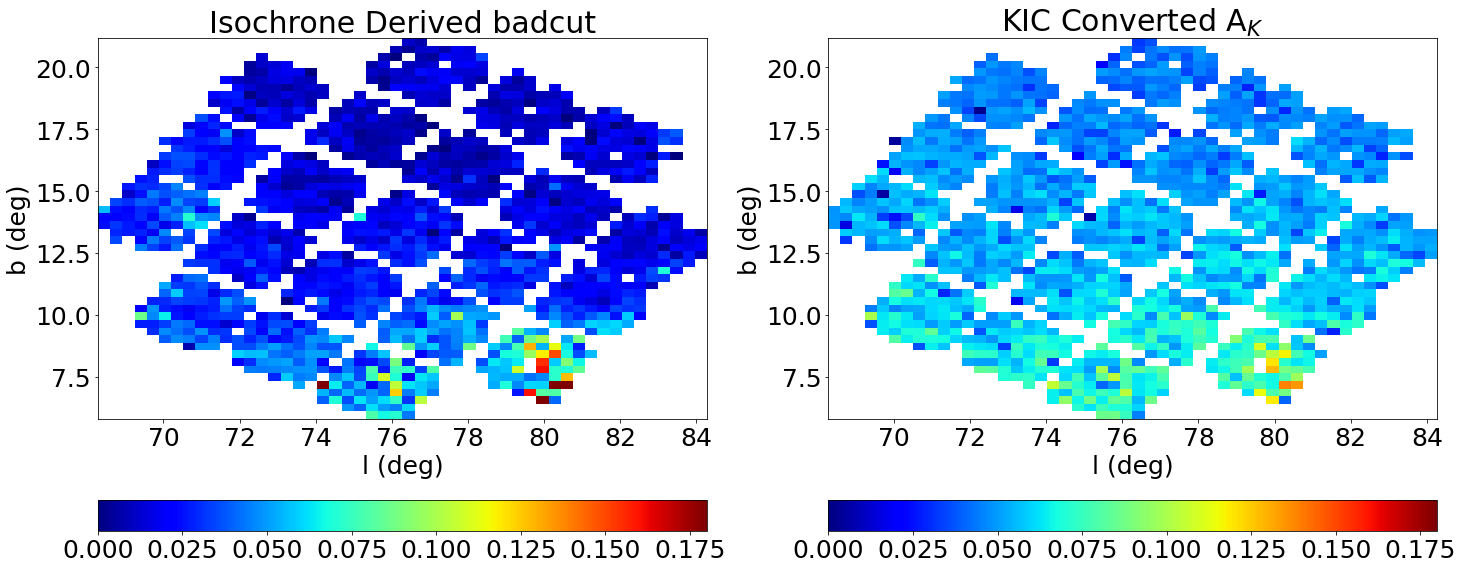

In [19]:
plt.figure(figsize=[24,10])

fincut = np.where((np.isfinite(agetab['AK'])==True)&(np.isfinite(k672dr17['KIC_EBMV'])==True)&
                  (agetab['AK']<10.)&(k672dr17['KIC_EBMV']>-10.))

plt.subplot(121)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],agetab['AK'][fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.,vmax=0.180)

plt.colorbar(orientation='horizontal')

plt.title(r'Isochrone Derived badcut')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

print('{:.5f}+/-{:.5f}'.format(np.median(agetab['AK'][fincut]),mad(agetab['AK'][fincut])))
print(np.mean(agetab['AK'][fincut]))
print('-----')

plt.subplot(122)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],k672dr17['KIC_EBMV'][fincut]*ak_ebv,
                          'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.,vmax=0.180)

plt.colorbar(orientation='horizontal')

plt.title(r'KIC Converted A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

print('{:.5f}+/-{:.5f}'.format(np.median(k672dr17['KIC_EBMV'][fincut]*ak_ebv),
                               mad(k672dr17['KIC_EBMV'][fincut]*ak_ebv)))
print(np.mean(k672dr17['KIC_EBMV'][fincut]*ak_ebv))

plt.savefig('../plots/kasc_ext_map.pdf',dpi=300,bbox_inches='tight')

plt.show()

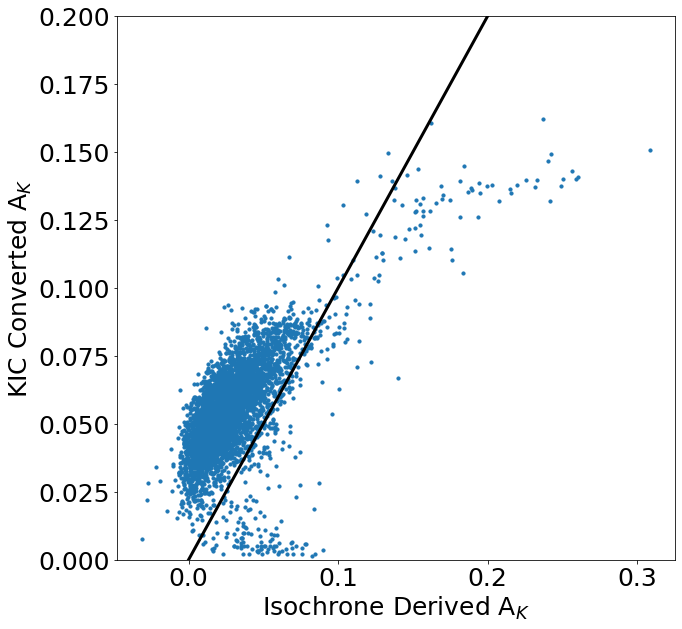

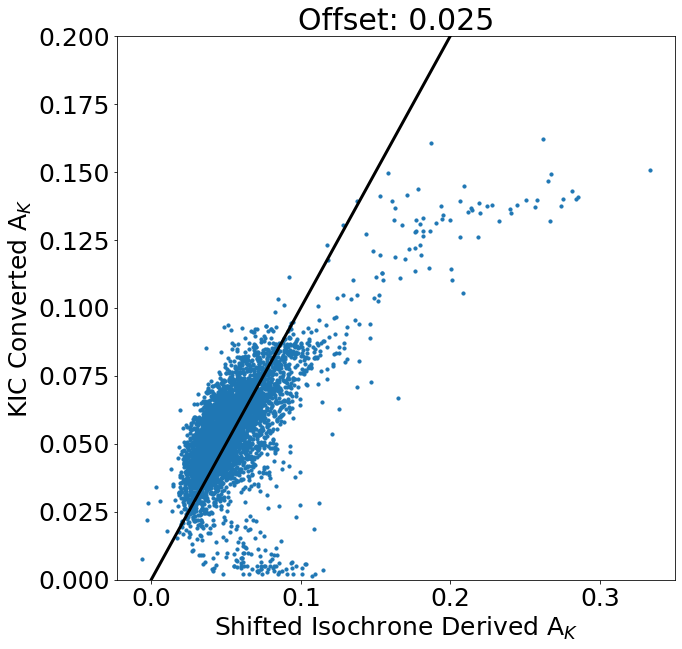

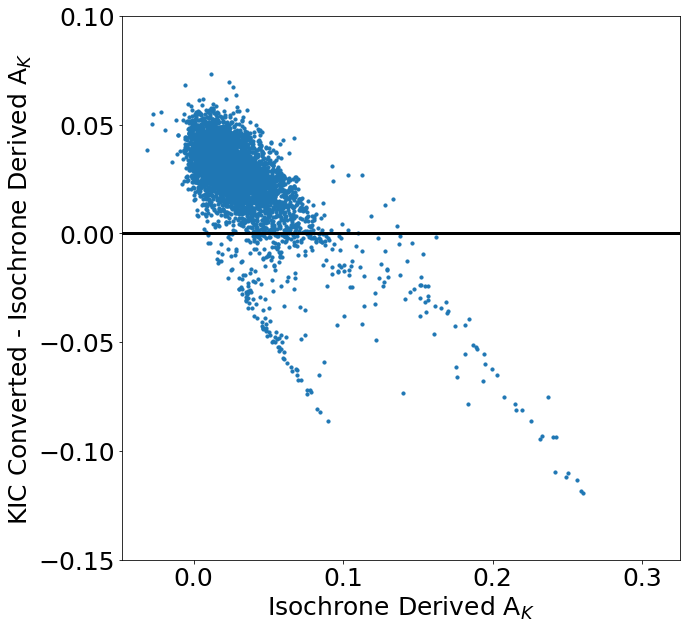

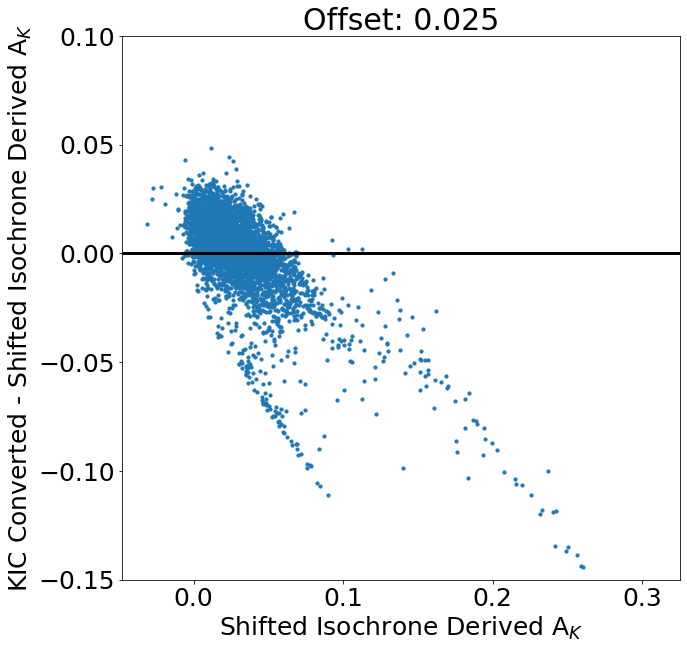

In [20]:
offset = 0.025

#####
plt.figure(figsize=[10,10])
plt.scatter(agetab['AK'][fincut],k672dr17['KIC_EBMV'][fincut]*ak_ebv,s=10)
plt.plot([0,0.25],[0,0.25],c='k',lw=3.0)

plt.ylim(0.00,0.2)

plt.xlabel(r'Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted A$_K$')
plt.show()

#####
plt.figure(figsize=[10,10])
plt.scatter(agetab['AK'][fincut]+offset,k672dr17['KIC_EBMV'][fincut]*ak_ebv,s=10)
plt.plot([0,0.25],[0,0.25],c='k',lw=3.0)

plt.ylim(0.00,0.2)

plt.title(r'Offset: {}'.format(offset))
plt.xlabel(r'Shifted Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted A$_K$')
plt.show()

#####
plt.figure(figsize=[10,10])
plt.scatter(agetab['AK'][fincut],k672dr17['KIC_EBMV'][fincut]*ak_ebv-agetab['AK'][fincut],s=10)
plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.15,0.1)

plt.xlabel(r'Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted - Isochrone Derived A$_K$')
plt.show()

#####
plt.figure(figsize=[10,10])
plt.scatter(agetab['AK'][fincut],k672dr17['KIC_EBMV'][fincut]*ak_ebv-agetab['AK'][fincut]-offset,s=10)
plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.15,0.1)

plt.title(r'Offset: {}'.format(offset))
plt.xlabel(r'Shifted Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted - Shifted Isochrone Derived A$_K$')
plt.show()

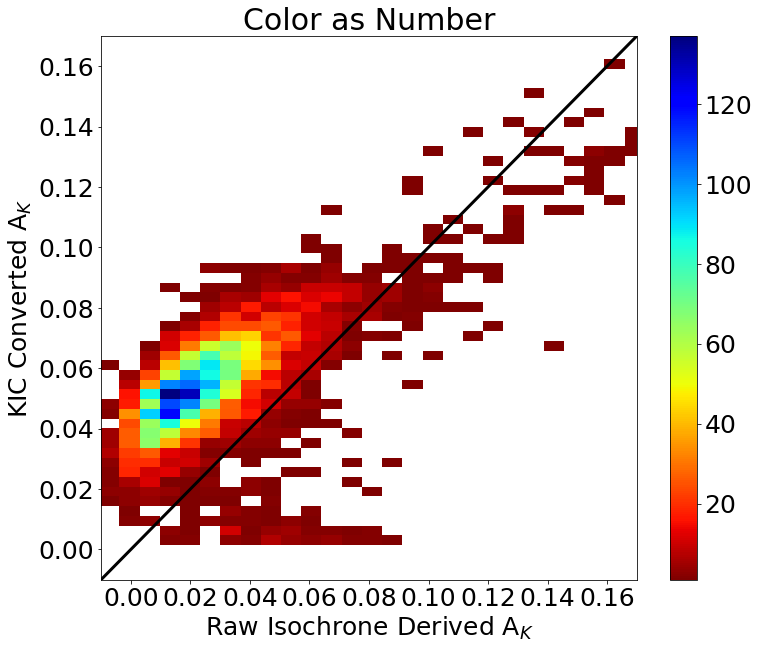

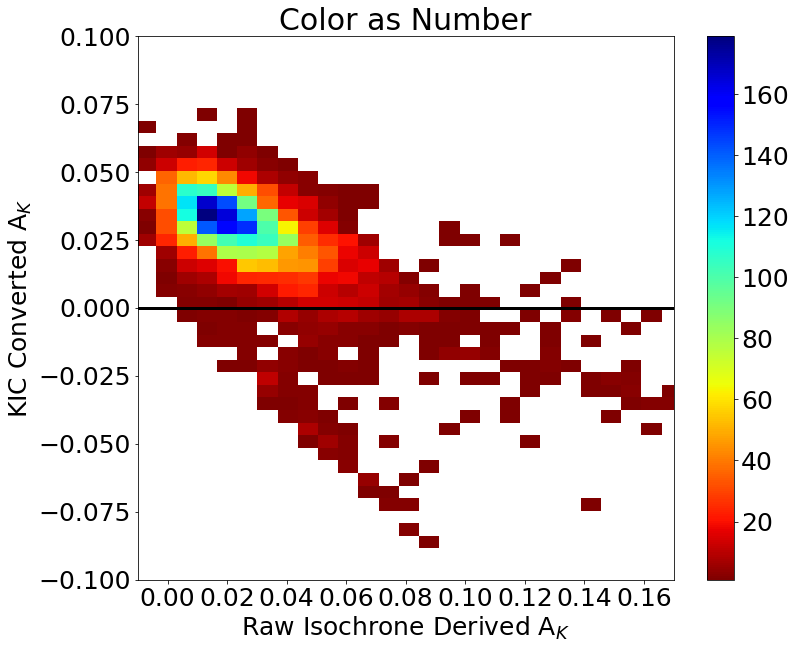

In [21]:
ret = binned_statistic_2d(agetab['AK'][fincut],k672dr17['KIC_EBMV'][fincut]*ak_ebv,
                          agetab['AK'][fincut],'count',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])
plt.imshow(ret.statistic.T, origin='lower',
               extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
               aspect='auto',interpolation='nearest',cmap='jet_r')
plt.colorbar()
plt.plot([-0.01,0.25],[-0.01,0.25],c='k',lw=3.0)

plt.xlim(-0.01,0.17)
plt.ylim(-0.01,0.17)

plt.xticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])
plt.yticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])

plt.title('Color as Number')
plt.xlabel(r'Raw Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted A$_K$')

plt.savefig('../plots/kasc_ak_kic_number.pdf',dpi=300,bbox_inches='tight')
plt.show()

##########
ret = binned_statistic_2d(agetab['AK'][fincut],k672dr17['KIC_EBMV'][fincut]*ak_ebv-agetab['AK'][fincut],
                          agetab['AK'][fincut],'count',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])
plt.imshow(ret.statistic.T, origin='lower',
               extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
               aspect='auto',interpolation='nearest',cmap='jet_r')
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)

plt.xlim(-0.01,0.17)
plt.ylim(-0.10,0.10)

plt.xticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])

plt.title(r'Color as Number')
plt.xlabel(r'Raw Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted A$_K$')

plt.savefig('../plots/kasc_ak_resid_number.pdf',dpi=300,bbox_inches='tight')
plt.show()

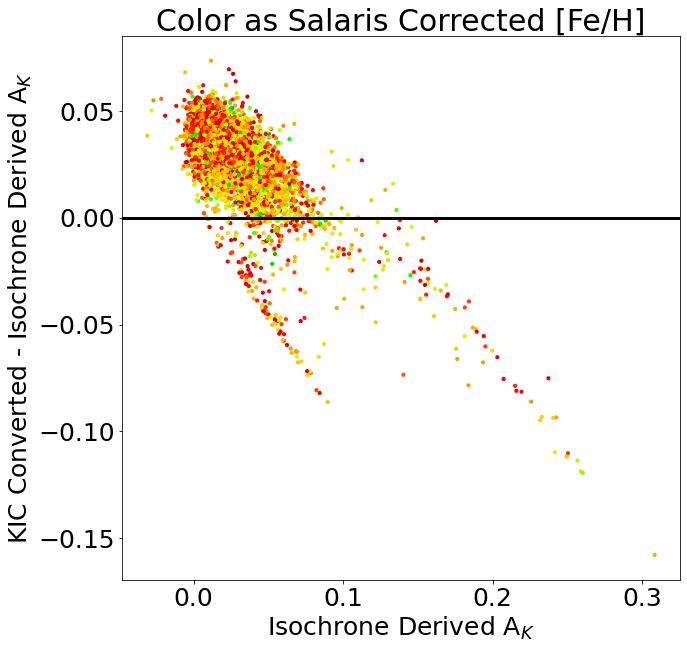

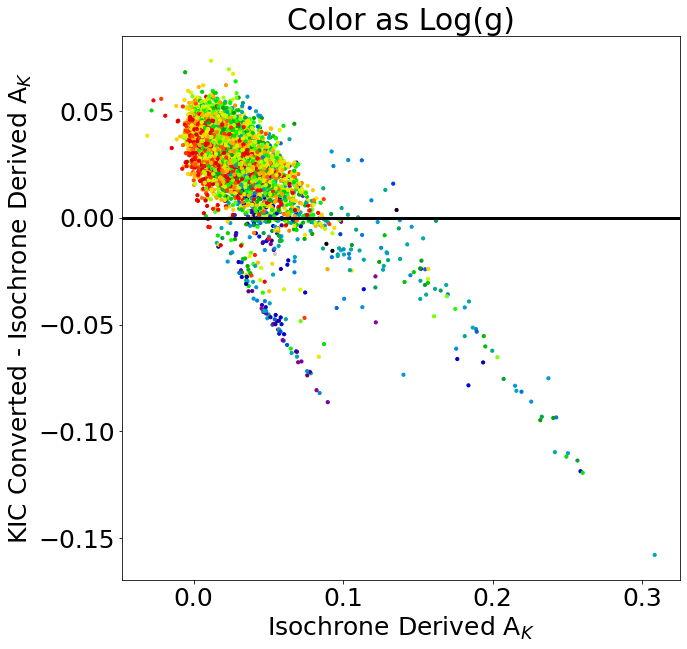

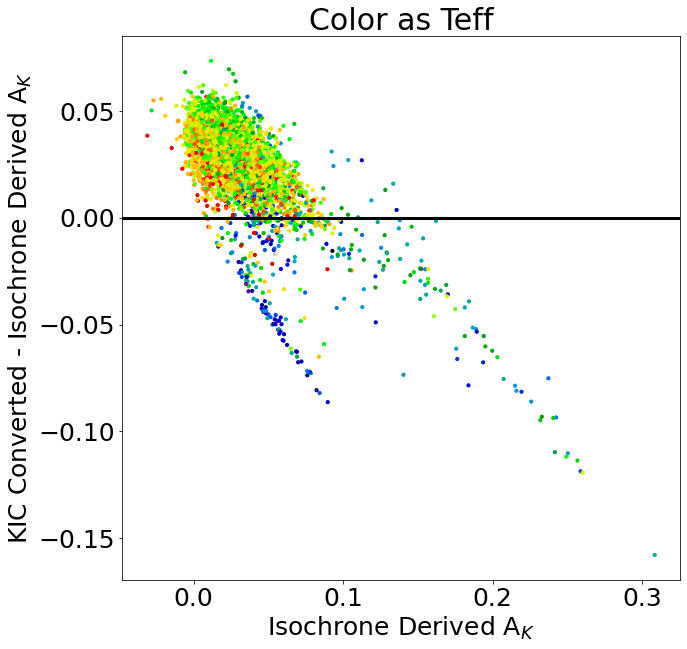

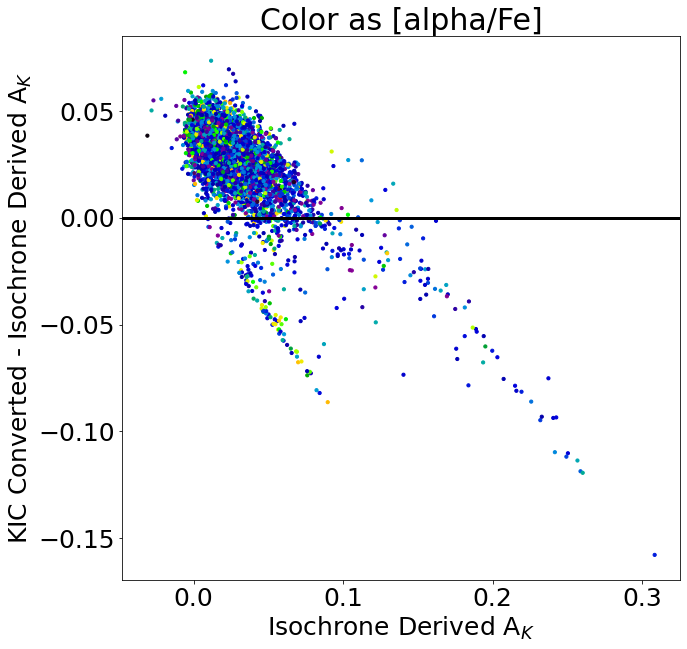

In [22]:
fincut = np.where((np.isfinite(agetab['AK'])==True)&(np.isfinite(k672dr17['KIC_EBMV'])==True)&
                  (agetab['AK']<10.)&(k672dr17['KIC_EBMV']>-10.))

resid_colors = np.array([salfeh,kdr17['LOGG'],kdr17['TEFF'],apoafe])
resid_labels = np.array(['Salaris Corrected [Fe/H]','Log(g)','Teff','[alpha/Fe]'])

for i in range(len(resid_colors)):
    plt.figure(figsize=[10,10])
    plt.scatter(agetab['AK'][fincut],(k672dr17['KIC_EBMV']*ak_ebv-agetab['AK'])[fincut],
                c=resid_colors[i][fincut],cmap='nipy_spectral',s=10)
    plt.axhline(0.0,c='k',lw=3.0)
    plt.title(r'Color as {}'.format(resid_labels[i]))
    plt.xlabel(r'Isochrone Derived A$_K$')
    plt.ylabel(r'KIC Converted - Isochrone Derived A$_K$')
    plt.show()

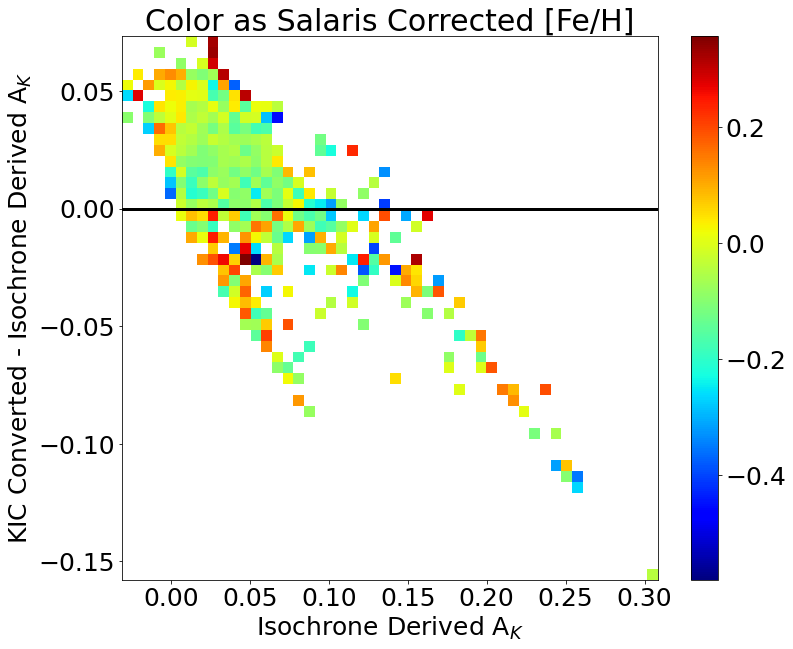

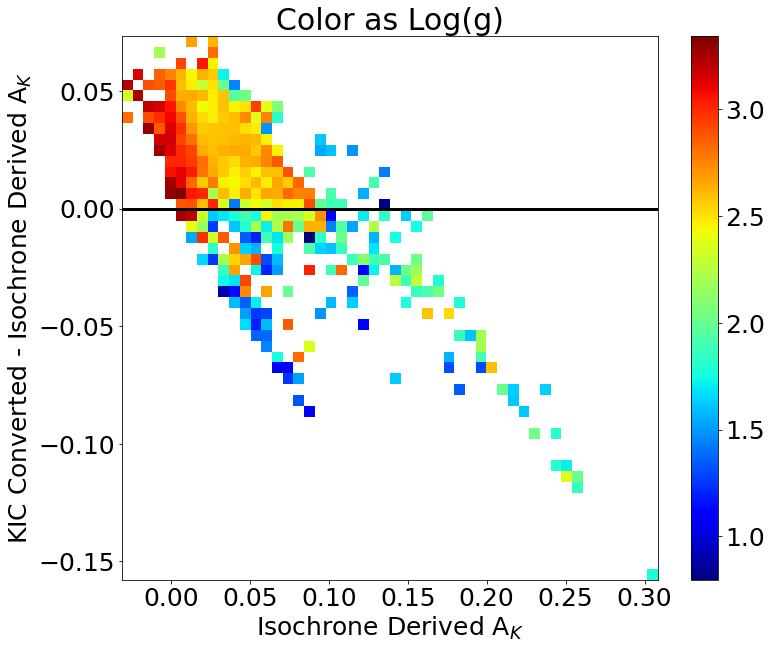

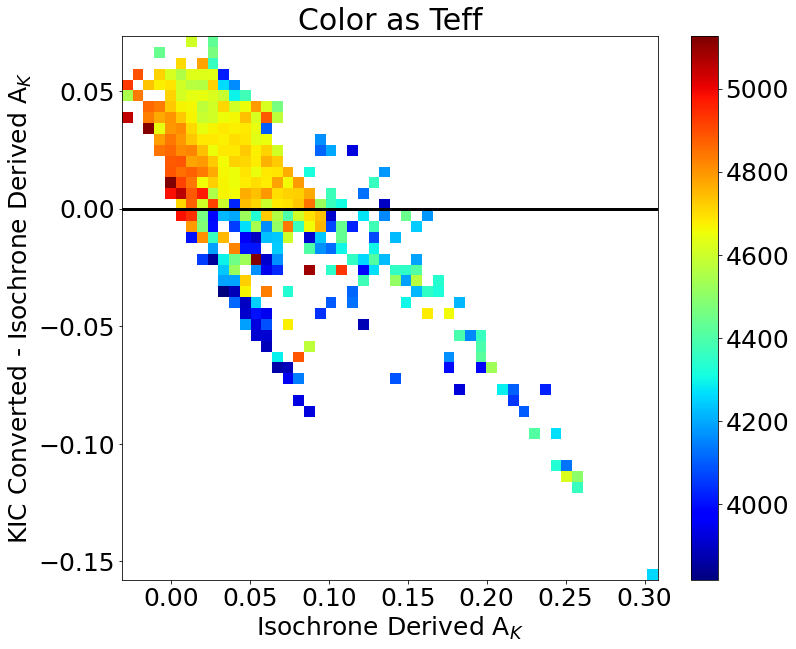

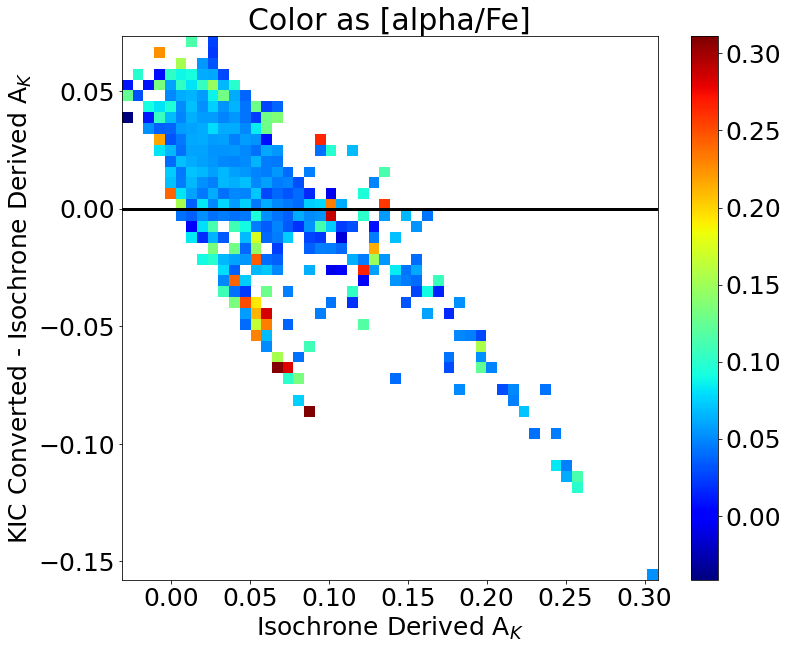

In [23]:
for i in range(len(resid_colors)):
    
    ret = binned_statistic_2d(agetab['AK'][fincut],(k672dr17['KIC_EBMV']*ak_ebv-agetab['AK'])[fincut],
                              resid_colors[i][fincut],'median',bins=50)
    
    plt.figure(figsize=[12,10])
    plt.imshow(ret.statistic.T, origin='lower',
               extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
               aspect='auto',interpolation='nearest',cmap='jet')
    plt.colorbar()
    plt.axhline(0.0,c='k',lw=3.0)
    plt.title(r'Color as {}'.format(resid_labels[i]))
    plt.xlabel(r'Isochrone Derived A$_K$')
    plt.ylabel(r'KIC Converted - Isochrone Derived A$_K$')
    plt.show()

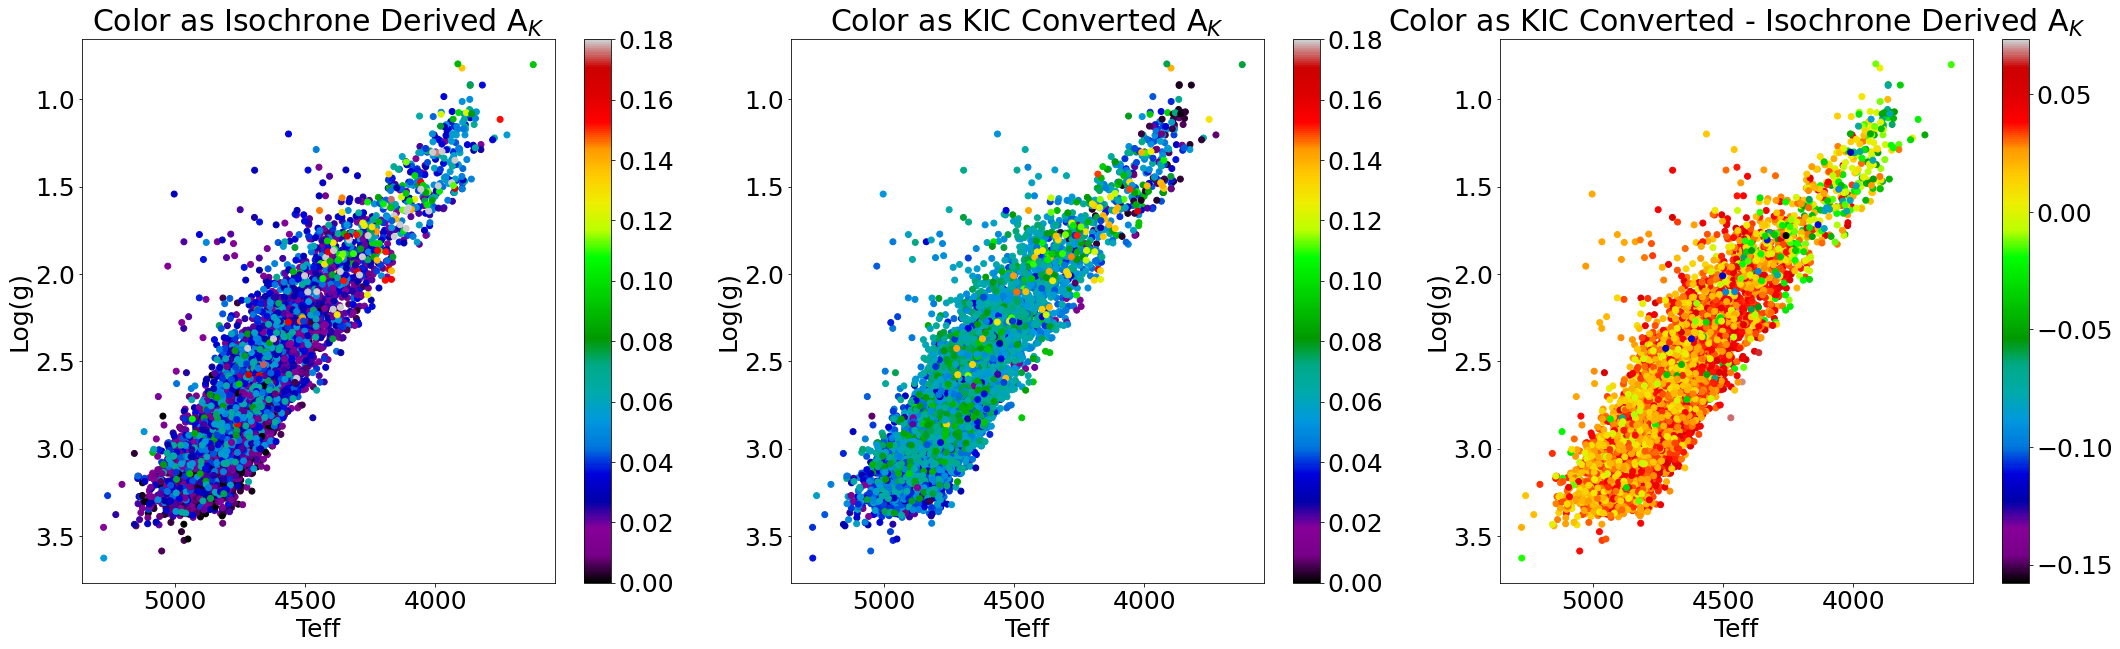

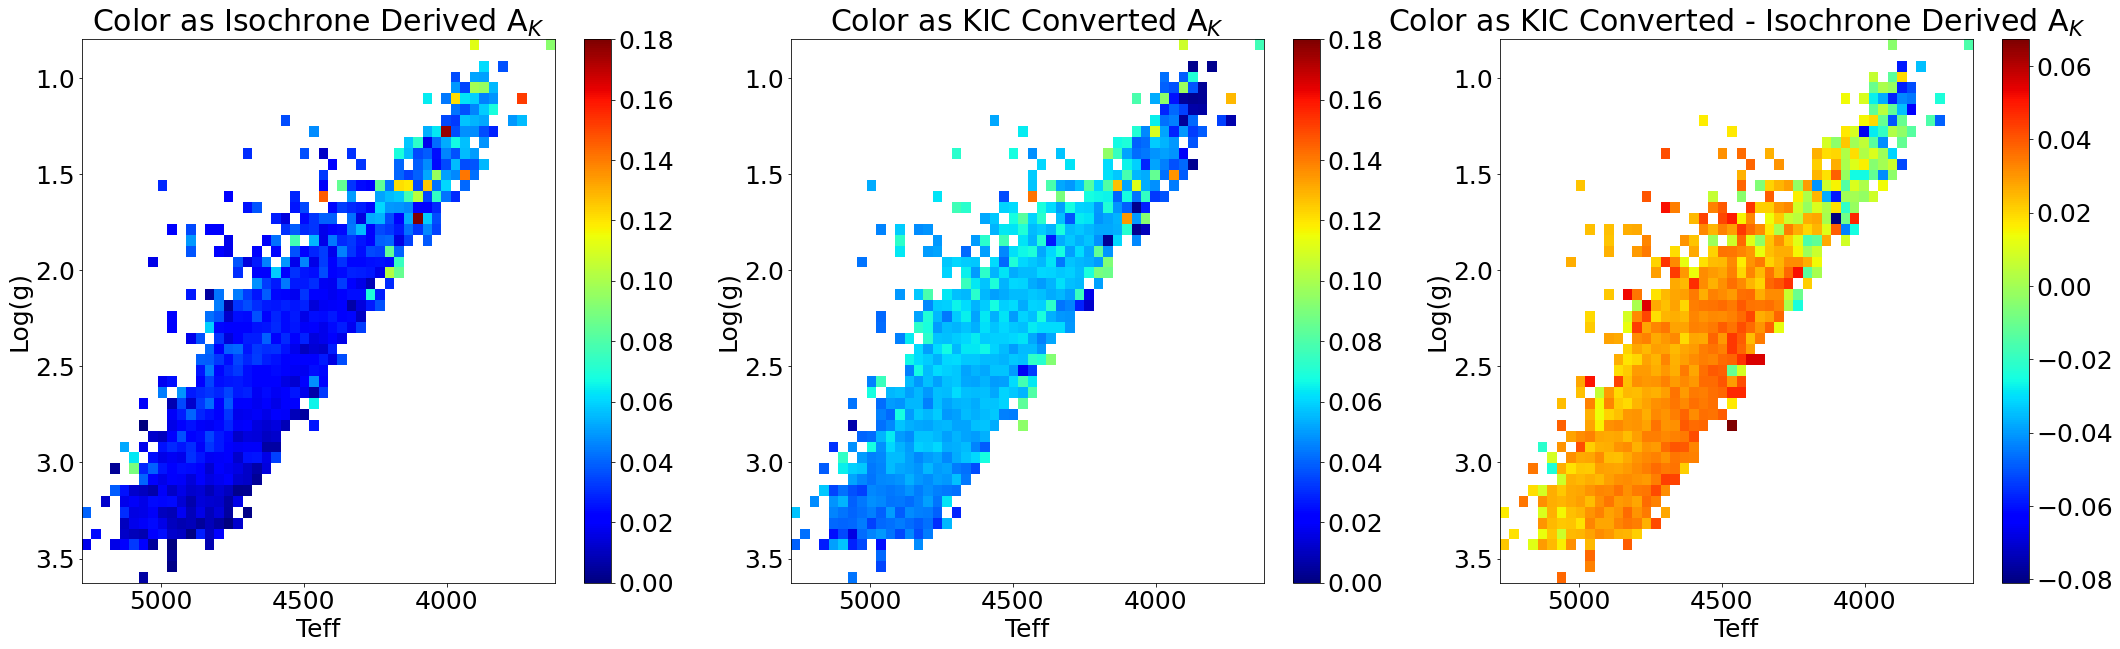

In [24]:
kic_bad = np.where((k672dr17['KIC_EBMV']>-10.)&(np.isfinite(k672dr17['KIC_EBMV'])==True)&
                   (np.isfinite(agetab['AK'])==True)&(np.isfinite(kdr17['TEFF'])==True)&
                   (np.isfinite(kdr17['LOGG'])==True))

plt.figure(figsize=[36,10])
plt.subplot(131)
plt.scatter(kdr17['TEFF'][kic_bad],kdr17['LOGG'][kic_bad],
            c=agetab['AK'][kic_bad],cmap='nipy_spectral',vmin=0,vmax=0.18)
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as Isochrone Derived A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.subplot(132)
plt.scatter(kdr17['TEFF'][kic_bad],kdr17['LOGG'][kic_bad],
            c=k672dr17['KIC_EBMV'][kic_bad]*ak_ebv,cmap='nipy_spectral',vmin=0,vmax=0.18)
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as KIC Converted A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.subplot(133)
plt.scatter(kdr17['TEFF'][kic_bad],kdr17['LOGG'][kic_bad],
            c=(k672dr17['KIC_EBMV']*ak_ebv-agetab['AK'])[kic_bad],cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as KIC Converted - Isochrone Derived A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.show()


################################
plt.figure(figsize=[36,10])
plt.subplot(131)
ret131 = binned_statistic_2d(kdr17['TEFF'][kic_bad],kdr17['LOGG'][kic_bad],
                             agetab['AK'][kic_bad],'median',bins=50)
plt.imshow(ret131.statistic.T, origin='lower',extent=[ret131.x_edge[0],
                                                      ret131.x_edge[-1],ret131.y_edge[0],ret131.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet',vmin=0,vmax=0.18)
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as Isochrone Derived A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.subplot(132)
ret132 = binned_statistic_2d(kdr17['TEFF'][kic_bad],kdr17['LOGG'][kic_bad],
                             k672dr17['KIC_EBMV'][kic_bad]*ak_ebv,'median',bins=50)
plt.imshow(ret132.statistic.T, origin='lower',
           extent=[ret132.x_edge[0],ret132.x_edge[-1],ret132.y_edge[0],ret132.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet',vmin=0,vmax=0.18)
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as KIC Converted A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.subplot(133)
ret133 = binned_statistic_2d(kdr17['TEFF'][kic_bad],kdr17['LOGG'][kic_bad],
                             k672dr17['KIC_EBMV'][kic_bad]*ak_ebv-agetab['AK'][kic_bad],'median',bins=50)
plt.imshow(ret133.statistic.T, origin='lower',
           extent=[ret133.x_edge[0],ret133.x_edge[-1],ret133.y_edge[0],ret133.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet')
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as KIC Converted - Isochrone Derived A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.show()

In [62]:
ak_ebv =0.3

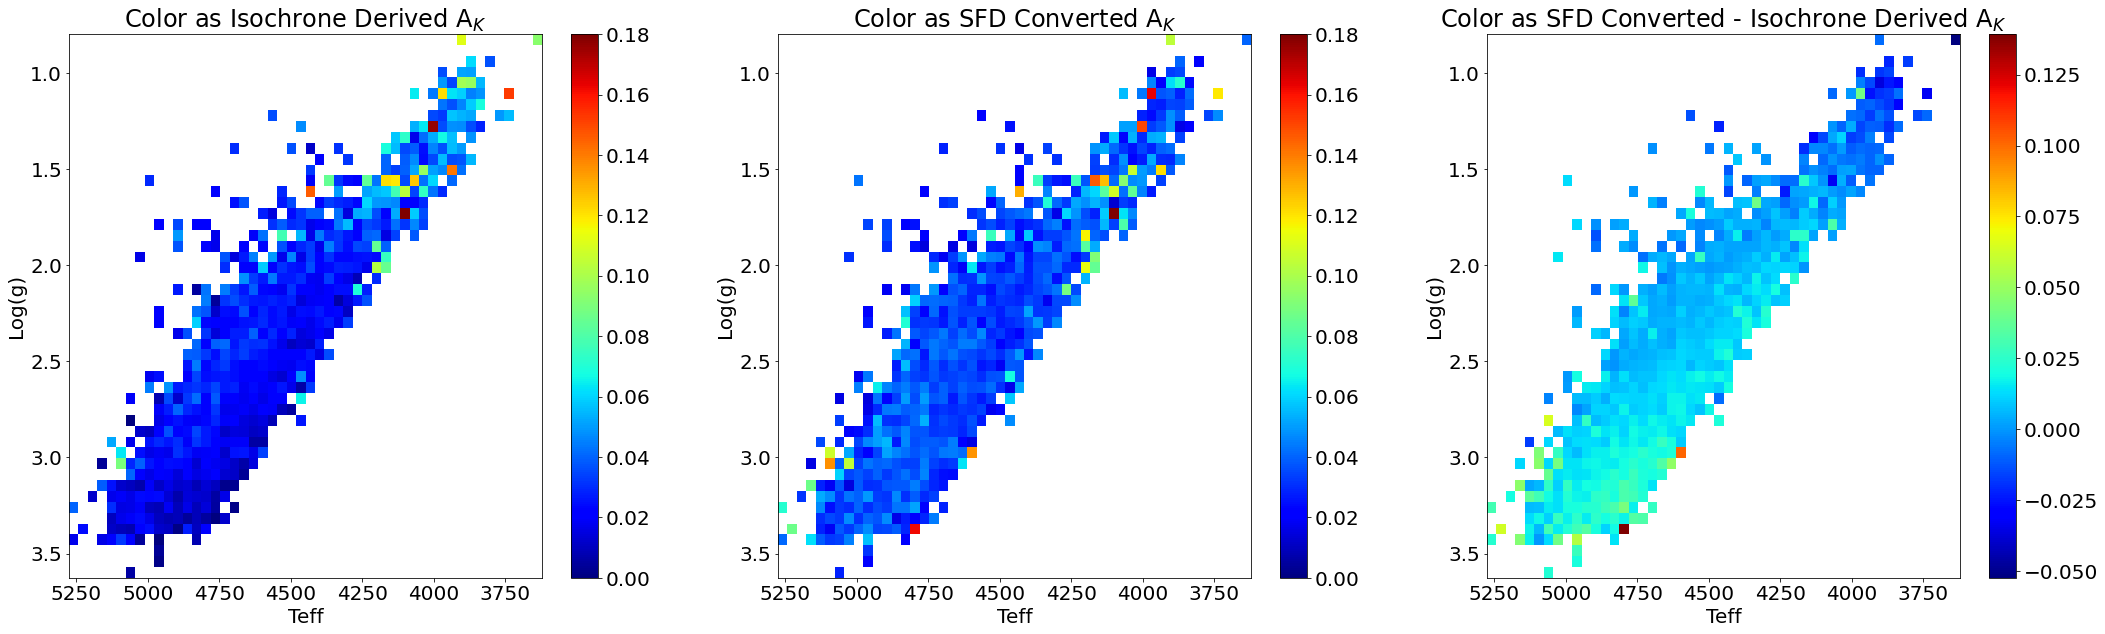

In [63]:
plt.figure(figsize=[36,10])
plt.subplot(131)
ret131 = binned_statistic_2d(kdr17['TEFF'][kic_bad],kdr17['LOGG'][kic_bad],
                             agetab['AK'][kic_bad],'median',bins=50)
plt.imshow(ret131.statistic.T, origin='lower',extent=[ret131.x_edge[0],
                                                      ret131.x_edge[-1],ret131.y_edge[0],ret131.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet',vmin=0,vmax=0.18)
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as Isochrone Derived A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.subplot(132)
ret132 = binned_statistic_2d(kdr17['TEFF'][kic_bad],kdr17['LOGG'][kic_bad],
                             kdr17['SFD_EBV'][kic_bad]*ak_ebv,'median',bins=50)
plt.imshow(ret132.statistic.T, origin='lower',
           extent=[ret132.x_edge[0],ret132.x_edge[-1],ret132.y_edge[0],ret132.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet',vmin=0,vmax=0.18)
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as SFD Converted A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.subplot(133)
ret133 = binned_statistic_2d(kdr17['TEFF'][kic_bad],kdr17['LOGG'][kic_bad],
                             kdr17['SFD_EBV'][kic_bad]*ak_ebv-agetab['AK'][kic_bad],'median',bins=50)
plt.imshow(ret133.statistic.T, origin='lower',
           extent=[ret133.x_edge[0],ret133.x_edge[-1],ret133.y_edge[0],ret133.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet')
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as SFD Converted - Isochrone Derived A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.show()

In [60]:
ak_ebv

0.3735961742948368

Text(0, 0.5, 'SFD Converted A$_K$')

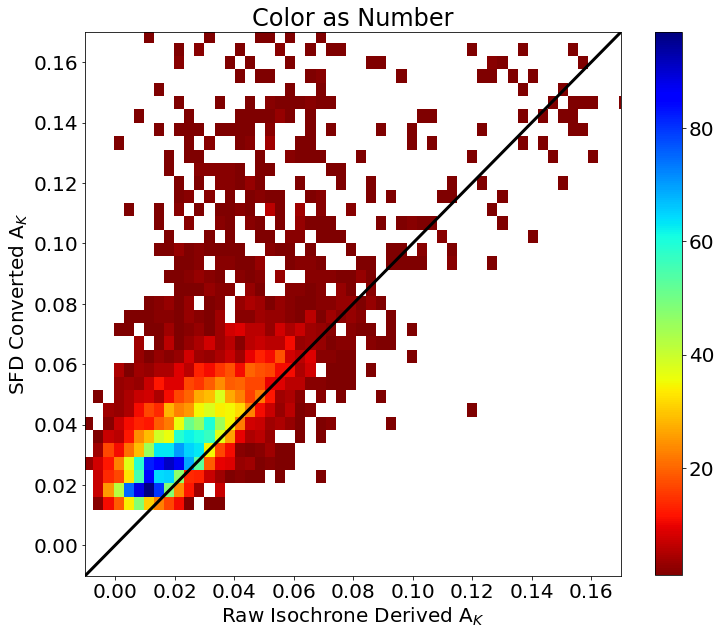

In [61]:
ret = binned_statistic_2d(agetab['AK'][fincut],kdr17['SFD_EBV'][fincut]*0.30,
                          agetab['AK'][fincut],'count',bins=100)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])
plt.imshow(ret.statistic.T, origin='lower',
               extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
               aspect='auto',interpolation='nearest',cmap='jet_r')
plt.colorbar()
plt.plot([-0.01,0.25],[-0.01,0.25],c='k',lw=3.0)

plt.xlim(-0.01,0.17)
plt.ylim(-0.01,0.17)

plt.xticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])
plt.yticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])

plt.title('Color as Number')
plt.xlabel(r'Raw Isochrone Derived A$_K$')
plt.ylabel(r'SFD Converted A$_K$')

Text(0, 0.5, 'SFD Converted A$_K$')

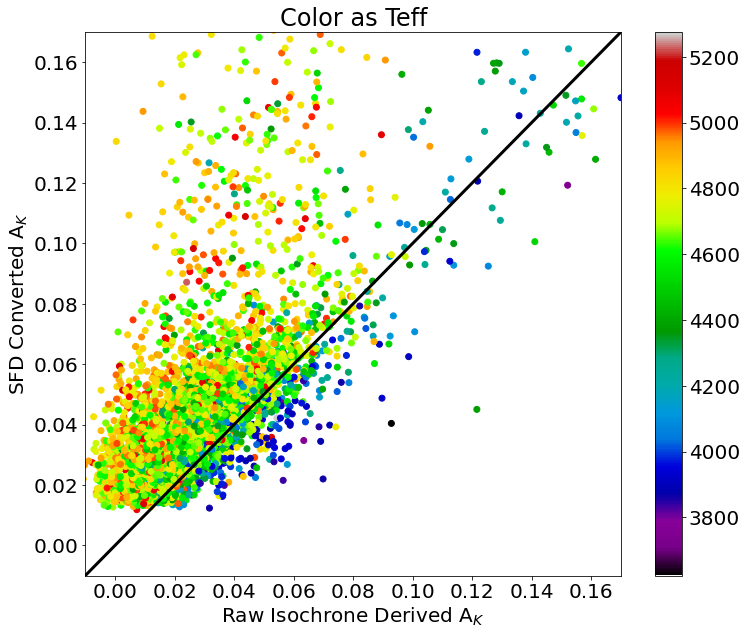

In [65]:
# ret = binned_statistic_2d(agetab['AK'][fincut],kdr17['SFD_EBV'][fincut]*0.30,
#                           agetab['AK'][fincut],'count',bins=100)

# ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])
# plt.imshow(ret.statistic.T, origin='lower',
#                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
#                aspect='auto',interpolation='nearest',cmap='jet_r')

plt.scatter(agetab['AK'][fincut],kdr17['SFD_EBV'][fincut]*0.30,c=kdr17['TEFF'][fincut],cmap='nipy_spectral')
plt.colorbar()
plt.plot([-0.01,0.25],[-0.01,0.25],c='k',lw=3.0)

plt.xlim(-0.01,0.17)
plt.ylim(-0.01,0.17)

plt.xticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])
plt.yticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])

plt.title('Color as Teff')
plt.xlabel(r'Raw Isochrone Derived A$_K$')
plt.ylabel(r'SFD Converted A$_K$')

Text(0, 0.5, 'SFD Converted - Raw Isochrone Derived A$_K$')

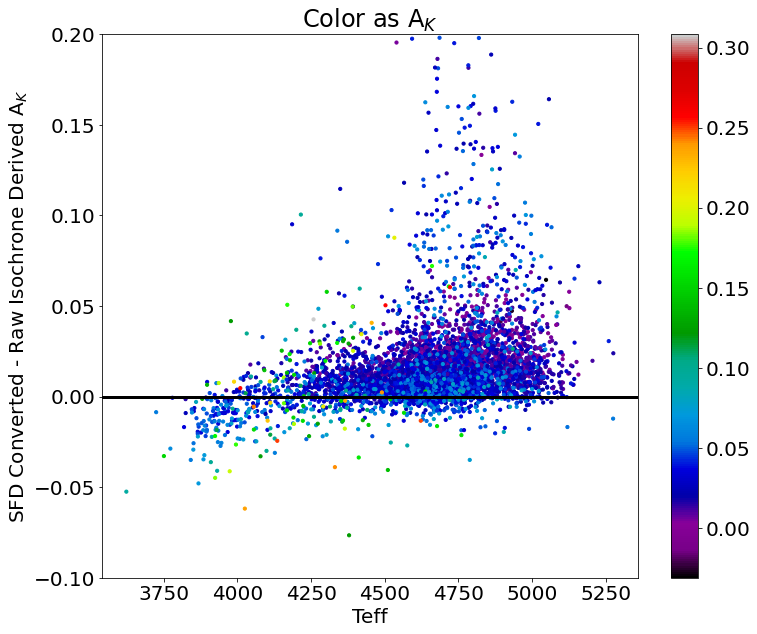

In [72]:
plt.figure(figsize=[12,10])
plt.scatter(kdr17['TEFF'][fincut],kdr17['SFD_EBV'][fincut]*0.30-agetab['AK'][fincut],
            c=agetab['AK'][fincut],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.1,0.2)

plt.title('Color as A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'SFD Converted - Raw Isochrone Derived A$_K$')

Text(0, 0.5, 'SFD Converted - Raw Isochrone Derived A$_K$')

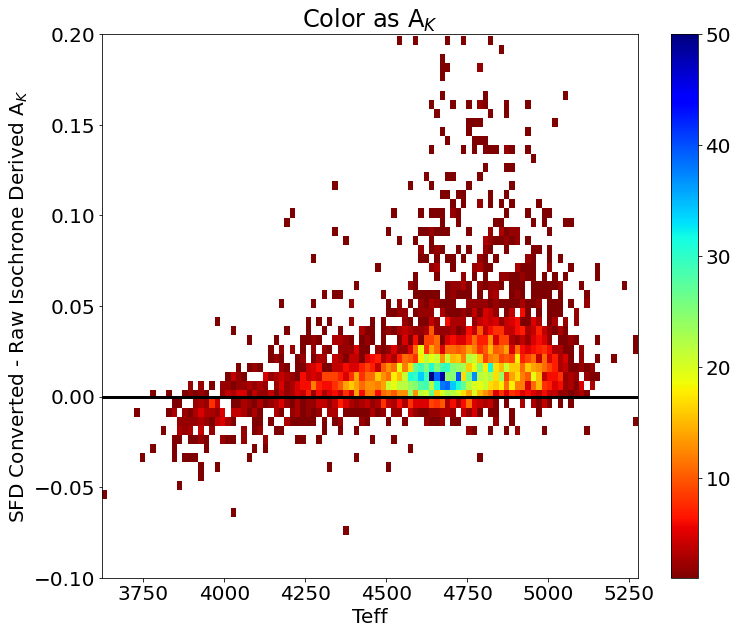

In [73]:
ret = binned_statistic_2d(kdr17['TEFF'][fincut],kdr17['SFD_EBV'][fincut]*0.30-agetab['AK'][fincut],
                          kdr17['TEFF'][fincut],'count',bins=100)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])
plt.imshow(ret.statistic.T, origin='lower',
               extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
               aspect='auto',interpolation='nearest',cmap='jet_r')


# plt.figure(figsize=[12,10])
# plt.scatter(kdr17['TEFF'][fincut],kdr17['SFD_EBV'][fincut]*0.30-agetab['AK'][fincut],
#             c=agetab['AK'][fincut],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.1,0.2)

plt.title('Color as A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'SFD Converted - Raw Isochrone Derived A$_K$')

Text(0, 0.5, 'Isochrone Derived Age')

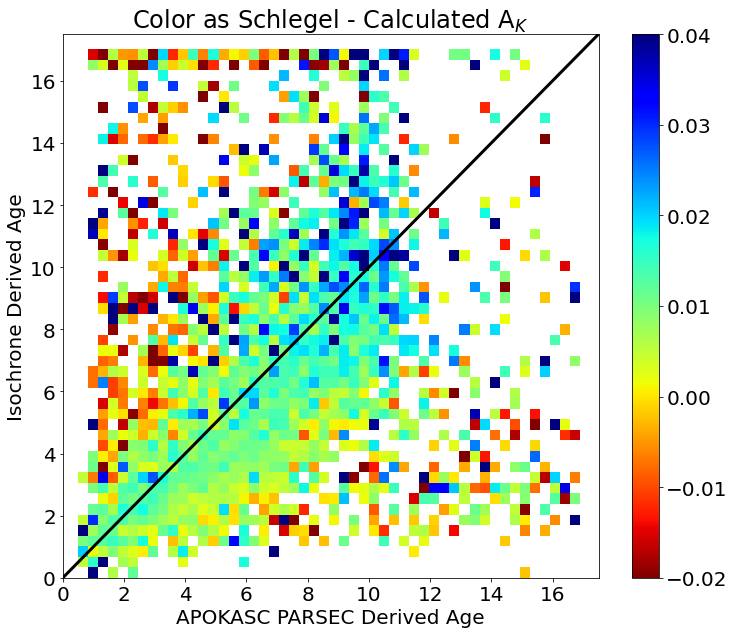

In [88]:
badcut = np.where(agetab['AGE']<999999.0)

xpk = agetab['PARSEC_AGE'][badcut]
ypk = agetab['AGE'][badcut]

fincut = np.where((np.isfinite(ypk)==True)&(np.isfinite(xpk)==True)&
                  (xpk>-20.)&(xpk<20.)&(ypk<20.)&(ypk>-20.)&(agetab['MASS'][badcut]<100.))

ret = binned_statistic_2d(xpk[fincut],ypk[fincut],(kdr17['SFD_EBV']*0.30-agetab['AK'])[badcut][fincut],'median',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])

plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
       aspect='auto',interpolation='nearest',cmap='jet_r',vmin=-0.02,vmax=0.04)
plt.colorbar()

plt.plot([0,18],[0,18],c='k',lw=3.0)

plt.xticks(np.arange(20)[::2])
plt.yticks(np.arange(20)[::2])

plt.ylim(0.,17.5)
plt.xlim(0.,17.5)

plt.title('Color as Schlegel - Calculated A$_K$')
plt.xlabel(r'APOKASC PARSEC Derived Age')
plt.ylabel(r'Isochrone Derived Age')

In [90]:
def upturn10Gyr(age):
    '''
    Boundary for 10 Gyr upturn in Aetas and APOKASC plot 
    
    Input:
    -----
        age: age in Gyr
        
    Output:
    ------
        ups: value on boundary 
    '''
    ups = np.ones(np.size(age))
    for i in range(np.size(age)):
        if age[i] <= 11:
            up = 11

        else:
            up = age[i]
            
        ups[i] = up

    return ups

upturnstars = np.where(agetab_uncal['AGE']-upturn10Gyr(agetab_uncal['PARSEC_AGE'])>0)

In [96]:
# np.where((agetab_uncal['AGE'][upturnstars]>14.9)&(agetab_uncal['AGE'][upturnstars]<15.1))

badstar = np.where(kdr17['APOGEE_ID']==agetab_uncal['NAME'][upturnstars][233])

In [121]:
print('BP',kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][badstar])
print('RP',kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][badstar])
print('J',kdr17['J'][badstar])
print('H',kdr17['H'][badstar])
print('K',kdr17['K'][badstar])

bad_obs = np.array([kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][badstar][0],
                   kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][badstar][0],
                   kdr17['J'][badstar][0],kdr17['H'][badstar][0],kdr17['K'][badstar][0]])

BP [12.1864]
RP [10.8251]
J [9.829]
H [9.235]
K [9.128]


In [124]:
i = int(np.squeeze(badstar))
# for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):
te = np.array([kdr17['TEFF'][i],kdr17['TEFF_ERR'][i]])
ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
               [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                kdr17['J'][i],kdr17['H'][i],
                kdr17['K'][i]],
               [bperr[i],rperr[i],kdr17['J_ERR'][i],
                kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

CalcAge = Aetas(te,ab,op,di,massive,rv=3.1)
CalcAge.extinction()

bad_calc = CalcAge.teff_2_appmags(kdr17['TEFF'][badstar],agetab_uncal['PARSEC_AGE'][badstar])
print(bad_calc)

[11.8068715  10.4826308   9.50183816  8.88444133  8.77411925]


In [123]:
bad_calc-bad_obs

array([-0.37952891, -0.34246914, -0.32716231, -0.35055833, -0.35388101])

In [127]:
(agetab['AK']-kdr17['SFD_EBV']*0.3)[badcut]

<Column name='AK' dtype='float64' length=6050>
 -0.018112287110666557
-0.0029740569662569244
 -0.006112827590138236
  -0.00831743033321563
 -0.003473941996709657
 -0.011671129782425647
-0.0016852100575018326
 -0.005257382845369311
 -0.002866914114853035
 -0.047307118268325496
 -0.018625165469953374
 -0.009628848524095568
                   ...
  -0.06038409379251597
  -0.17542613200802776
 -0.008239909013692787
  -0.42320290098924357
  -0.37214928445687423
 -0.050380270836205054
0.00027076615983939734
   -0.2934142922563082
  -0.30387653231000056
   -0.2584453027478187
   -0.0426109517186139
  -0.24171140194257237

Text(0, 0.5, 'Isochrone Derived Age')

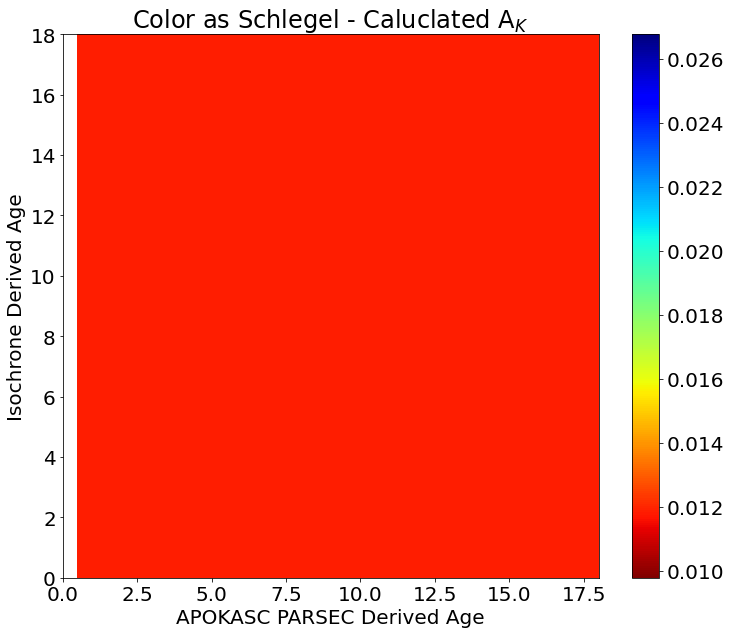

In [76]:
ret = binned_statistic_2d(agetab_uncal['PARSEC_AGE'][fincut],agetab_uncal['AGE'][fincut],
                          kdr17['SFD_EBV'][fincut]*0.30-agetab['AK'][fincut],'median',bins=100)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])
plt.imshow(ret.statistic.T, origin='lower',
               extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
               aspect='auto',interpolation='nearest',cmap='jet_r')

plt.colorbar()
# plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(0.,18)
plt.xlim(0.,18)

plt.title('Color as Schlegel - Caluclated A$_K$')
plt.xlabel(r'APOKASC PARSEC Derived Age')
plt.ylabel(r'Isochrone Derived Age')

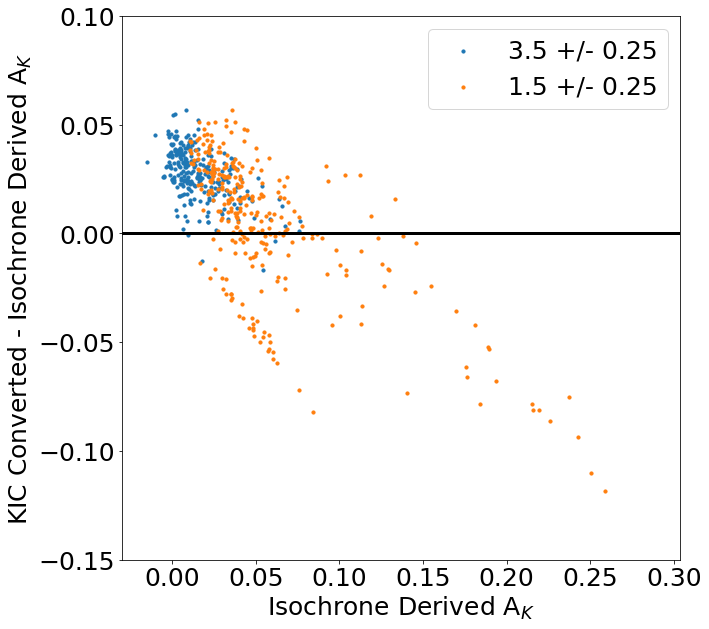

In [25]:
g35 = np.where((kdr17['logg']<3.75)&(kdr17['logg']>3.25))
g15 = np.where((kdr17['logg']<1.75)&(kdr17['logg']>1.25))

plt.figure(figsize=[10,10])
plt.scatter(agetab['AK'][g35],(k672dr17['KIC_EBMV']*ak_ebv-agetab['AK'])[g35],s=10,label='3.5 +/- 0.25')
plt.scatter(agetab['AK'][g15],(k672dr17['KIC_EBMV']*ak_ebv-agetab['AK'])[g15],s=10,label='1.5 +/- 0.25')

plt.legend()
plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.15,0.1)

plt.xlabel(r'Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted - Isochrone Derived A$_K$')
plt.show()

In [ ]:
t4800 = np.where((kdr17['TEFF']<4850)&(kdr17['TEFF']>4750))
t4000 = np.where((kdr17['TEFF']<4050)&(kdr17['TEFF']>3950))

plt.figure(figsize=[10,10])
plt.scatter(agetab['AK'][t4800],(k672dr17['KIC_EBMV']*ak_ebv-agetab['AK'])[t4800],s=10,label='4800 +/- 50')
plt.scatter(agetab['AK'][t4000],(k672dr17['KIC_EBMV']*ak_ebv-agetab['AK'])[t4000],s=10,label='4200 +/- 50')

plt.legend()
plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.15,0.1)

plt.xlabel(r'Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted - Isochrone Derived A$_K$')
plt.show()

In [27]:
def ak_calib1(X,a,b,c,d):
    ak,logg = X
    return a*ak**2+b*ak+c*logg+d

fincut = np.where((np.isfinite(k672dr17['KIC_EBMV'])==True)&(np.isfinite(agetab['AK'])==True)&
                  (k672dr17['KIC_EBMV']>0.)&(agetab['AK']>0.)&
                  np.isfinite(kdr17['LOGG'])&(kdr17['LOGG']>-0.5))

param_labels = np.array(['a','b','c','d'])
popt_ak_calib1, _ = curve_fit(ak_calib1,[agetab['AK'][fincut],kdr17['logg'][fincut]],
                         (k672dr17['KIC_EBMV']*ak_ebv-agetab['AK'])[fincut],p0=[-1,-1,-1,0])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_ak_calib1[i]))


Fit Parameters:
a = -0.33111
b = -0.46234
c = 0.00298
d = 0.03247


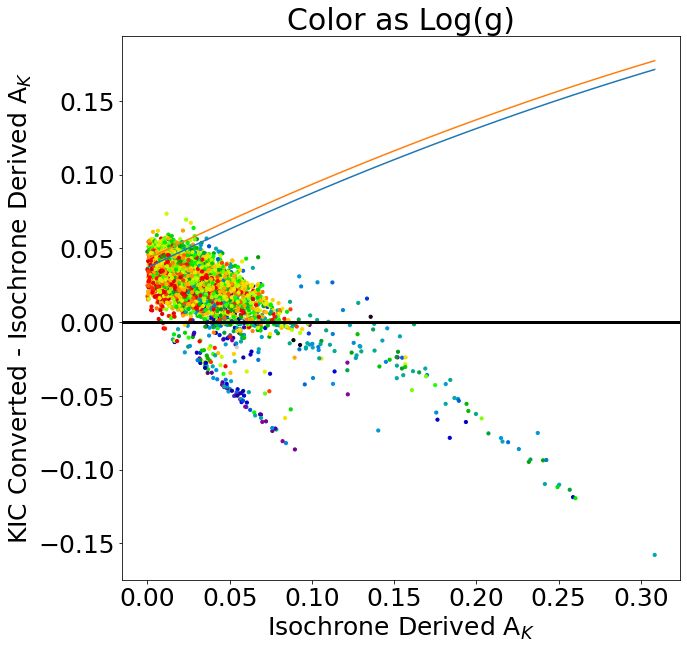

In [28]:
plt.figure(figsize=[10,10])
plt.scatter(agetab['AK'][fincut],(k672dr17['KIC_EBMV']*ak_ebv-agetab['AK'])[fincut],
            c=kdr17['LOGG'][fincut],cmap='nipy_spectral',s=10)

ak_xs = np.linspace(min(agetab['AK'][fincut]),max(agetab['AK'][fincut]))

plt.plot(ak_xs,ak_xs+ak_calib1([ak_xs,1.5],*popt_ak_calib1))
plt.plot(ak_xs,ak_xs+ak_calib1([ak_xs,3.5],*popt_ak_calib1))

plt.axhline(0.0,c='k',lw=3.0)
plt.title(r'Color as Log(g)')
plt.xlabel(r'Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted - Isochrone Derived A$_K$')
plt.show()

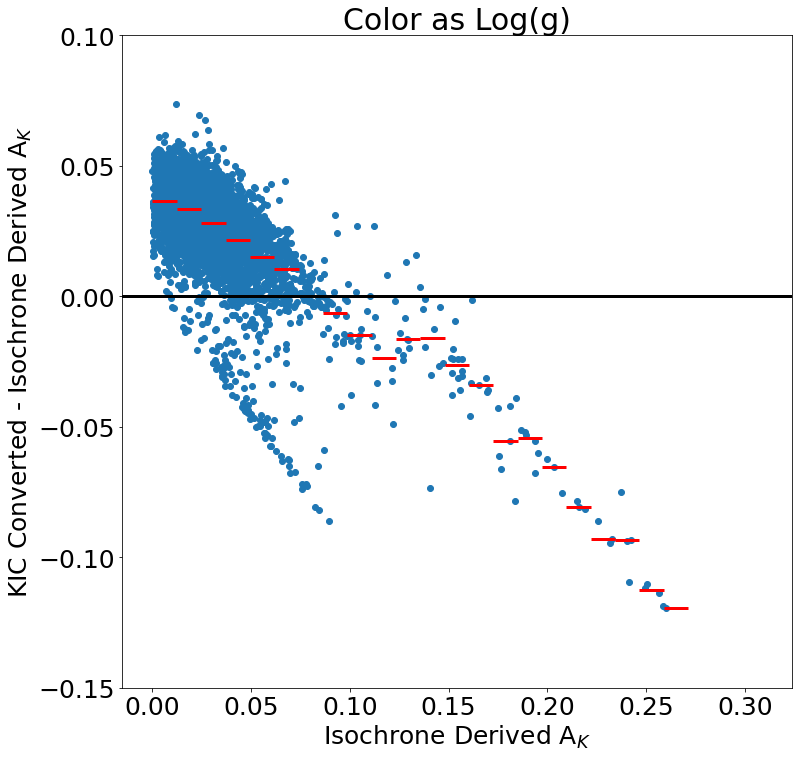

In [29]:
bin_medians,bin_edges,_ = binned_statistic(agetab['AK'][fincut],
                                           (k672dr17['KIC_EBMV']*ak_ebv-agetab['AK'])[fincut],
                                           statistic='median',bins=25)
bin_centers = (bin_edges[:-1]+np.diff(bin_edges)/2)

plt.figure(figsize=[12,12])
plt.scatter(agetab['AK'][fincut],(k672dr17['KIC_EBMV']*ak_ebv-agetab['AK'])[fincut])
plt.axhline(0.0,c='k',lw=3.0)
plt.hlines(bin_medians,bin_edges[:-1],bin_edges[1:],colors='r',lw=3.)

plt.ylim(-0.15,0.1)

plt.title(r'Color as Log(g)')
plt.xlabel(r'Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted - Isochrone Derived A$_K$')
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fit Parameters:
ak0 = 0.12500
a = -1.85323
b = -0.32056
c = 0.03917
d = -0.91372
e = -0.45103
f = 0.06226


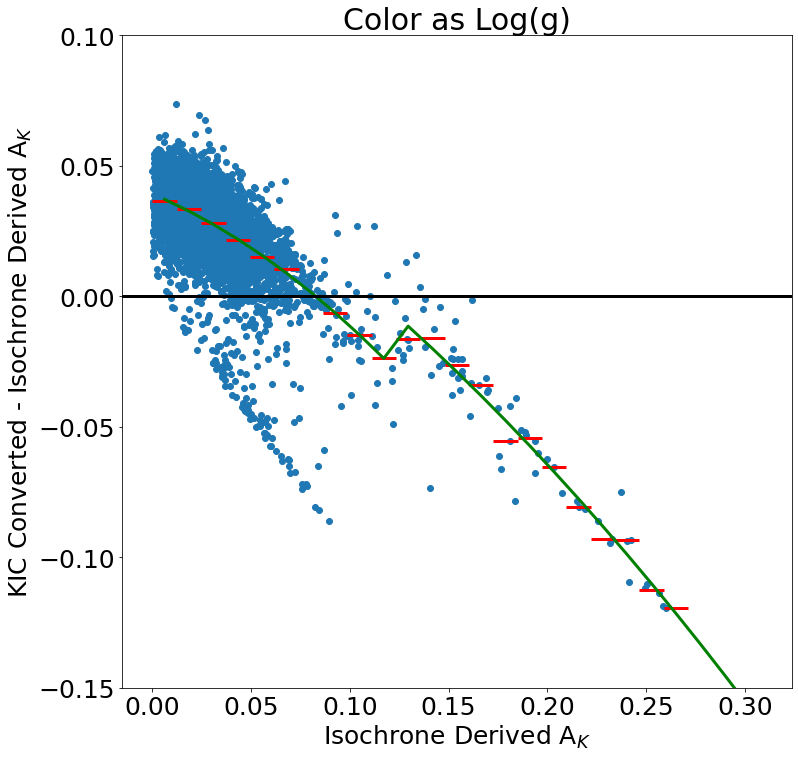

In [30]:
def ak_calib(x,ak0,a,b,c,d,e,f):
    return np.piecewise(x,[x<ak0],[lambda x: a*x**2+b*x+c,
                                   lambda x: d*x**2+e*x+f])

bincut = np.where((np.isfinite(bin_medians)==True)&(np.isfinite(bin_centers)==True))

param_labels = np.array(['ak0','a','b','c','d','e','f'])
popt_ak_calib, _ = curve_fit(ak_calib,bin_centers[bincut],bin_medians[bincut],p0=[0.125,-1,1,1,-1,1,1])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_ak_calib[i]))
    
plt.figure(figsize=[12,12])
plt.scatter(agetab['AK'][fincut],(k672dr17['KIC_EBMV']*ak_ebv-agetab['AK'])[fincut])
plt.plot(bin_centers,ak_calib(bin_centers,*popt_ak_calib),c='g',lw=3.0)
plt.axhline(0.0,c='k',lw=3.0)
plt.hlines(bin_medians,bin_edges[:-1],bin_edges[1:],colors='r',lw=3.)

plt.ylim(-0.15,0.1)

plt.title(r'Color as Log(g)')
plt.xlabel(r'Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted - Isochrone Derived A$_K$')
plt.show()

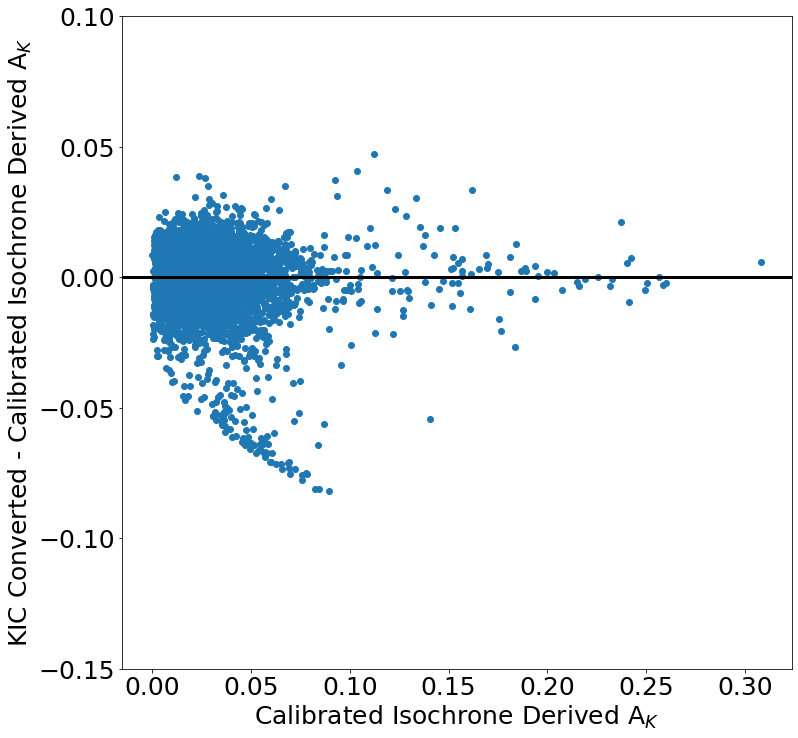

In [31]:
plt.figure(figsize=[12,12])
plt.scatter(agetab['AK'][fincut],
            (k672dr17['KIC_EBMV']*ak_ebv-(agetab['AK']+ak_calib(agetab['AK'],*popt_ak_calib)))[fincut])
plt.axhline(0.0,c='k',lw=3.0)
# plt.hlines(bin_medians,bin_edges[:-1],bin_edges[1:],colors='r',lw=3.)

plt.ylim(-0.15,0.1)

plt.xlabel(r'Calibrated Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted - Calibrated Isochrone Derived A$_K$')
plt.show()

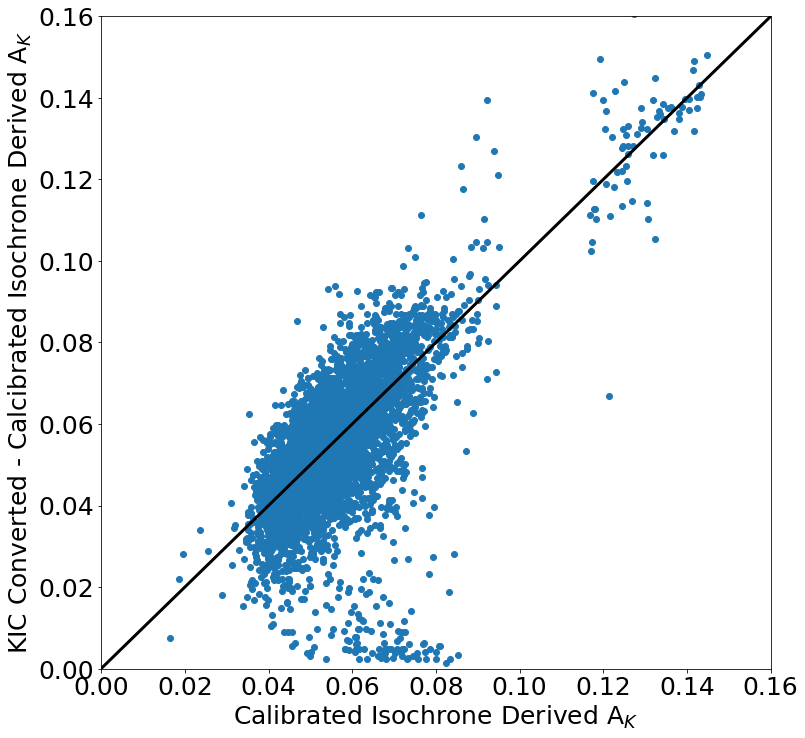

In [32]:
plt.figure(figsize=[12,12])
plt.scatter(agetab['AK']+ak_calib(agetab['AK'],*popt_ak_calib),k672dr17['KIC_EBMV']*ak_ebv)
plt.plot([0,0.16],[0,0.16],c='k',lw=3.0)

plt.xlim(0,0.16)
plt.ylim(0,0.16)

plt.xlabel(r'Calibrated Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted - Calcibrated Isochrone Derived A$_K$')
plt.show()

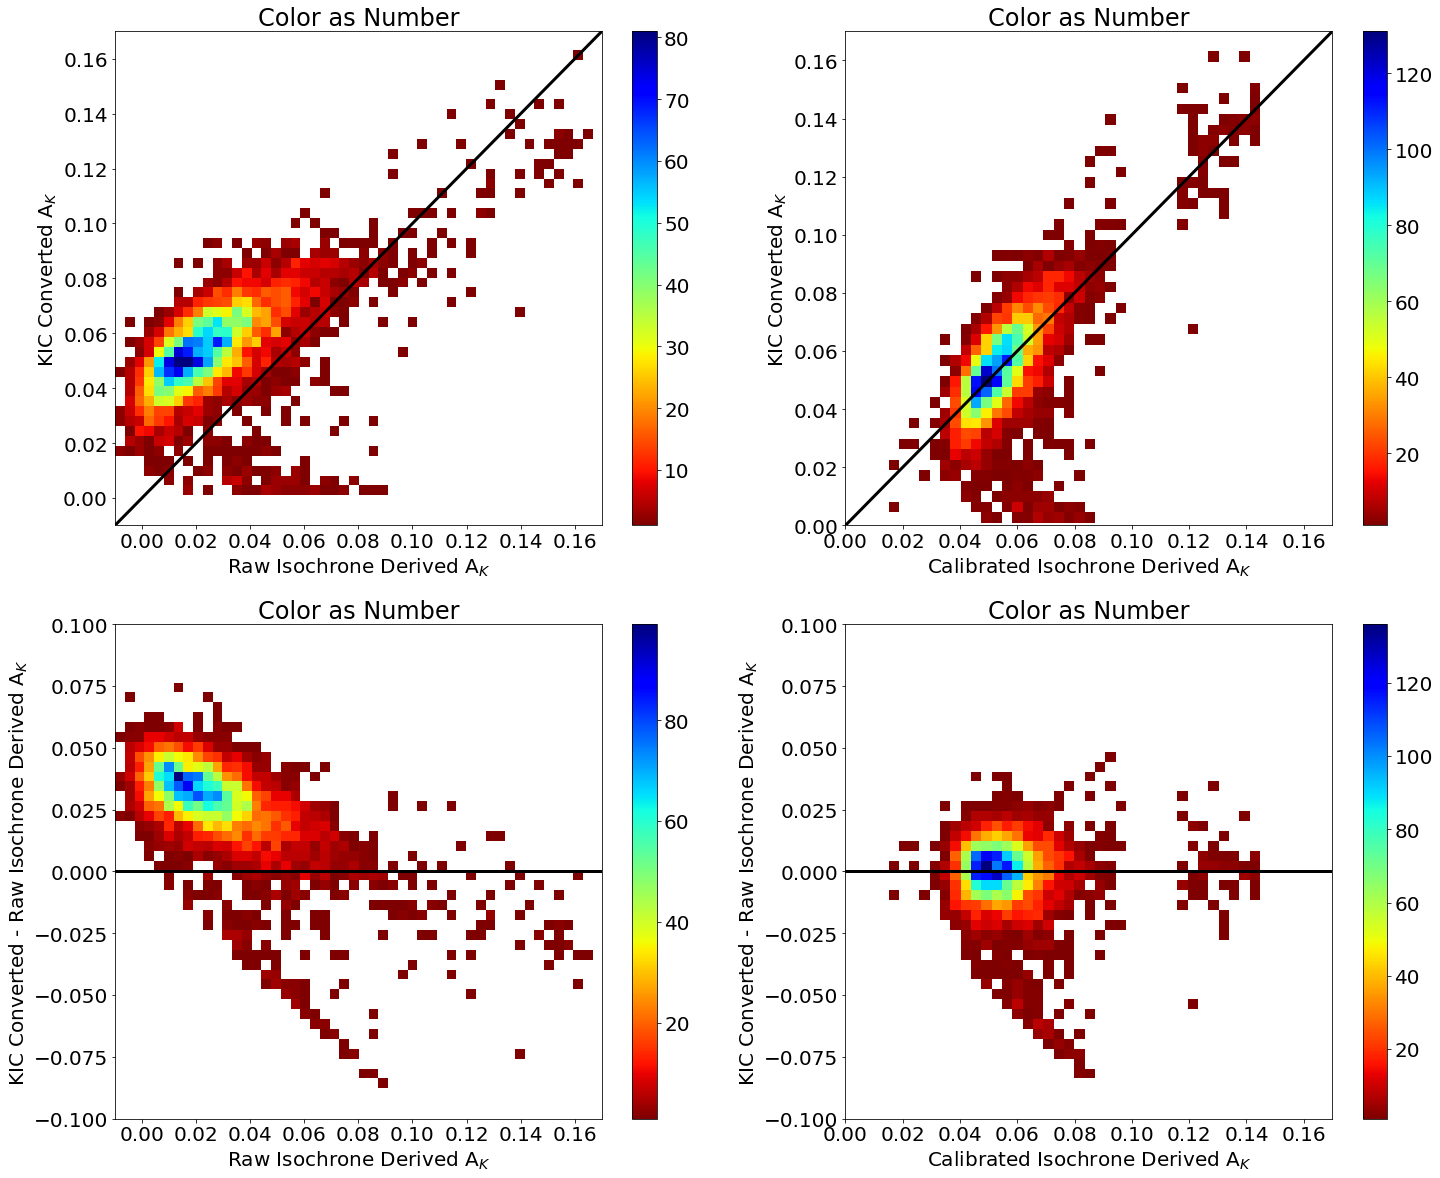

In [33]:
matplotlib.rcParams.update({'font.size': 20})
fincut = np.where((np.isfinite(agetab['AK'])==True)&(np.isfinite(k672dr17['KIC_EBMV'])==True)&
                  (agetab['AK']<10.)&(k672dr17['KIC_EBMV']>-10.))


plt.figure(figsize=[24,20])
plt.subplot(221)
ret = binned_statistic_2d(agetab['AK'][fincut],k672dr17['KIC_EBMV'][fincut]*ak_ebv,
                          agetab['AK'][fincut],'count',
                          bins=[np.arange(-0.01,0.17,(0.17+0.01)/50),np.arange(-0.01,0.17,(0.17+0.01)/50)])

ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',
               extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
               aspect='auto',interpolation='nearest',cmap='jet_r')
plt.colorbar()
plt.plot([-0.01,0.25],[-0.01,0.25],c='k',lw=3.0)

plt.xlim(-0.01,0.17)
plt.ylim(-0.01,0.17)

plt.xticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])
plt.yticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])

plt.title('Color as Number')
plt.xlabel(r'Raw Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted A$_K$')

##########
plt.subplot(222)
ret = binned_statistic_2d(agetab['AK'][fincut]+ak_calib(agetab['AK'][fincut],*popt_ak_calib),
                          k672dr17['KIC_EBMV'][fincut]*ak_ebv,
                          agetab['AK'][fincut]+ak_calib(agetab['AK'][fincut],*popt_ak_calib),'count',
                          bins=[np.arange(-0.01,0.17,(0.17+0.01)/50),np.arange(-0.01,0.17,(0.17+0.01)/50)])

ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',
               extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
               aspect='auto',interpolation='nearest',cmap='jet_r')
plt.colorbar()
plt.plot([-0.01,0.25],[-0.01,0.25],c='k',lw=3.0)

plt.xlim(-0.00,0.17)
plt.ylim(-0.00,0.17)

plt.xticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])
plt.yticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])

plt.title('Color as Number')
plt.xlabel(r'Calibrated Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted A$_K$')

##########
plt.subplot(223)
ret = binned_statistic_2d(agetab['AK'][fincut],k672dr17['KIC_EBMV'][fincut]*ak_ebv-agetab['AK'][fincut],
                          agetab['AK'][fincut],'count',
                          bins=[np.arange(-0.01,0.17,(0.17+0.01)/50),np.arange(-0.1,0.1,0.2/50)])

ret.statistic[ret.statistic == 0.0] = np.nan

plt.imshow(ret.statistic.T, origin='lower',
               extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
               aspect='auto',interpolation='nearest',cmap='jet_r')
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)

plt.xlim(-0.01,0.17)
plt.ylim(-0.10,0.10)

plt.xticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])

plt.title(r'Color as Number')
plt.xlabel(r'Raw Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted - Raw Isochrone Derived A$_K$')

##########
plt.subplot(224)
ret = binned_statistic_2d((agetab['AK']+ak_calib(agetab['AK'],*popt_ak_calib))[fincut],
                          (k672dr17['KIC_EBMV']*ak_ebv-(agetab['AK']+ak_calib(agetab['AK'],*popt_ak_calib)))[fincut],
                          (agetab['AK']+ak_calib(agetab['AK'],*popt_ak_calib))[fincut],'count',
                          bins=[np.arange(-0.01,0.17,(0.17+0.01)/50),np.arange(-0.1,0.1,0.2/50)])

ret.statistic[ret.statistic == 0.0] = np.nan

plt.imshow(ret.statistic.T, origin='lower',
               extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
               aspect='auto',interpolation='nearest',cmap='jet_r')
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)

plt.xlim(-0.00,0.17)
plt.ylim(-0.10,0.10)

plt.xticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])

plt.title(r'Color as Number')
plt.xlabel(r'Calibrated Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted - Raw Isochrone Derived A$_K$')

plt.savefig('../plots/kasc_ak_cal_number.pdf',dpi=300,bbox_inches='tight')
plt.show()

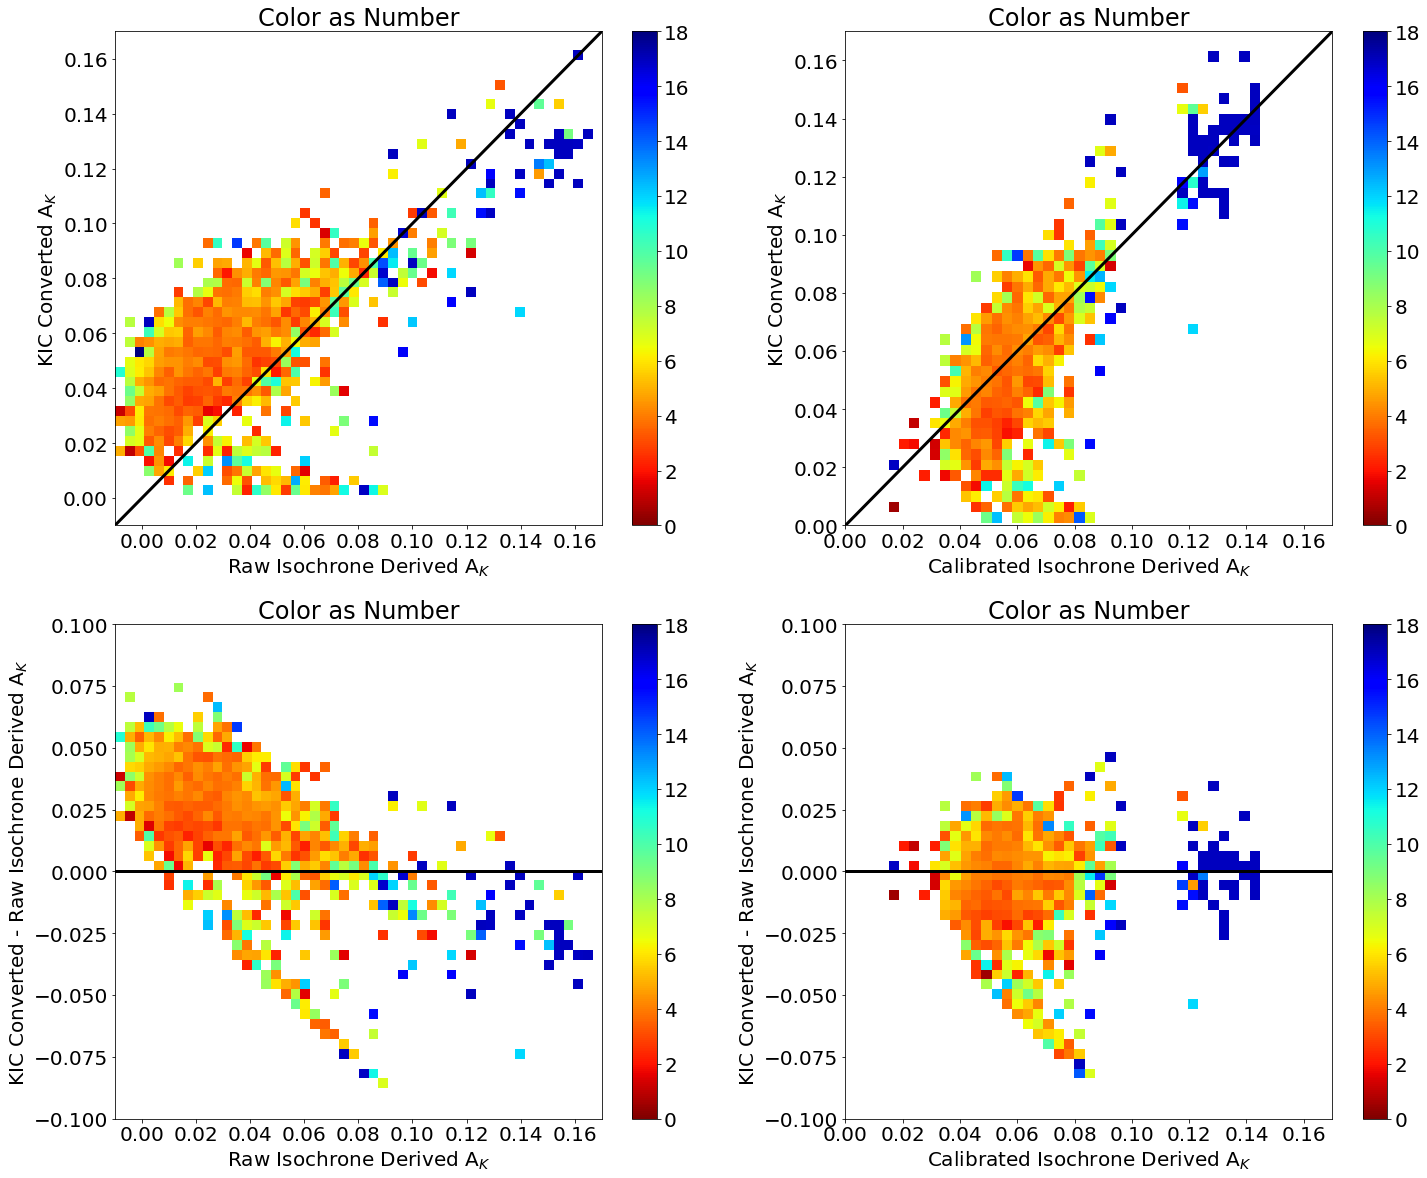

In [44]:
matplotlib.rcParams.update({'font.size': 20})
fincut = np.where((np.isfinite(agetab['AK'])==True)&(np.isfinite(k672dr17['KIC_EBMV'])==True)&
                  (agetab['AK']<10.)&(k672dr17['KIC_EBMV']>-10.))


plt.figure(figsize=[24,20])
plt.subplot(221)
ret = binned_statistic_2d(agetab['AK'][fincut],k672dr17['KIC_EBMV'][fincut]*ak_ebv,
                          agetab['AGE'][fincut],'median',
                          bins=[np.arange(-0.01,0.17,(0.17+0.01)/50),np.arange(-0.01,0.17,(0.17+0.01)/50)])

ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',
               extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
               aspect='auto',interpolation='nearest',cmap='jet_r',vmin=0,vmax=18)
plt.colorbar()
plt.plot([-0.01,0.25],[-0.01,0.25],c='k',lw=3.0)

plt.xlim(-0.01,0.17)
plt.ylim(-0.01,0.17)

plt.xticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])
plt.yticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])

plt.title('Color as Number')
plt.xlabel(r'Raw Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted A$_K$')

##########
plt.subplot(222)
ret = binned_statistic_2d(agetab['AK'][fincut]+ak_calib(agetab['AK'][fincut],*popt_ak_calib),
                          k672dr17['KIC_EBMV'][fincut]*ak_ebv,
                          agetab['AGE'][fincut],'median',
                          bins=[np.arange(-0.01,0.17,(0.17+0.01)/50),np.arange(-0.01,0.17,(0.17+0.01)/50)])

ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r',vmin=0,vmax=18)
plt.colorbar()
plt.plot([-0.01,0.25],[-0.01,0.25],c='k',lw=3.0)

plt.xlim(-0.00,0.17)
plt.ylim(-0.00,0.17)

plt.xticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])
plt.yticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])

plt.title('Color as Number')
plt.xlabel(r'Calibrated Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted A$_K$')

##########
plt.subplot(223)
ret = binned_statistic_2d(agetab['AK'][fincut],k672dr17['KIC_EBMV'][fincut]*ak_ebv-agetab['AK'][fincut],
                          agetab['AGE'][fincut],'median',
                          bins=[np.arange(-0.01,0.17,(0.17+0.01)/50),np.arange(-0.1,0.1,0.2/50)])

ret.statistic[ret.statistic == 0.0] = np.nan

plt.imshow(ret.statistic.T, origin='lower',
               extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
               aspect='auto',interpolation='nearest',cmap='jet_r',vmin=0,vmax=18)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)

plt.xlim(-0.01,0.17)
plt.ylim(-0.10,0.10)

plt.xticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])

plt.title(r'Color as Number')
plt.xlabel(r'Raw Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted - Raw Isochrone Derived A$_K$')

##########
plt.subplot(224)
ret = binned_statistic_2d((agetab['AK']+ak_calib(agetab['AK'],*popt_ak_calib))[fincut],
                          (k672dr17['KIC_EBMV']*ak_ebv-(agetab['AK']+ak_calib(agetab['AK'],*popt_ak_calib)))[fincut],
                          agetab['AGE'][fincut],'median',
                          bins=[np.arange(-0.01,0.17,(0.17+0.01)/50),np.arange(-0.1,0.1,0.2/50)])

ret.statistic[ret.statistic == 0.0] = np.nan

plt.imshow(ret.statistic.T, origin='lower',
               extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
               aspect='auto',interpolation='nearest',cmap='jet_r',vmin=0,vmax=18)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)

plt.xlim(-0.00,0.17)
plt.ylim(-0.10,0.10)

plt.xticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])

plt.title(r'Color as Number')
plt.xlabel(r'Calibrated Isochrone Derived A$_K$')
plt.ylabel(r'KIC Converted - Raw Isochrone Derived A$_K$')
plt.show()

(array([2.84e+02, 3.87e+03, 1.42e+03, 2.53e+02, 1.18e+02, 6.30e+01,
        2.80e+01, 1.00e+01, 8.00e+00, 2.00e+00]),
 array([-0.03094277,  0.00298498,  0.03691273,  0.07084048,  0.10476823,
         0.13869598,  0.17262373,  0.20655148,  0.24047923,  0.27440698,
         0.30833473]),
 <a list of 10 Patch objects>)

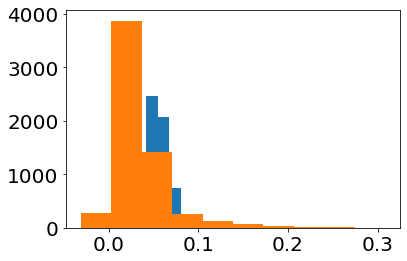

In [34]:
plt.hist(agetab['AK']+ak_calib(agetab['AK'],*popt_ak_calib))
plt.hist(agetab['AK'])

0.05421+/-0.00689
0.028667425441711747
-----
0.05380+/-0.00934
0.054958336


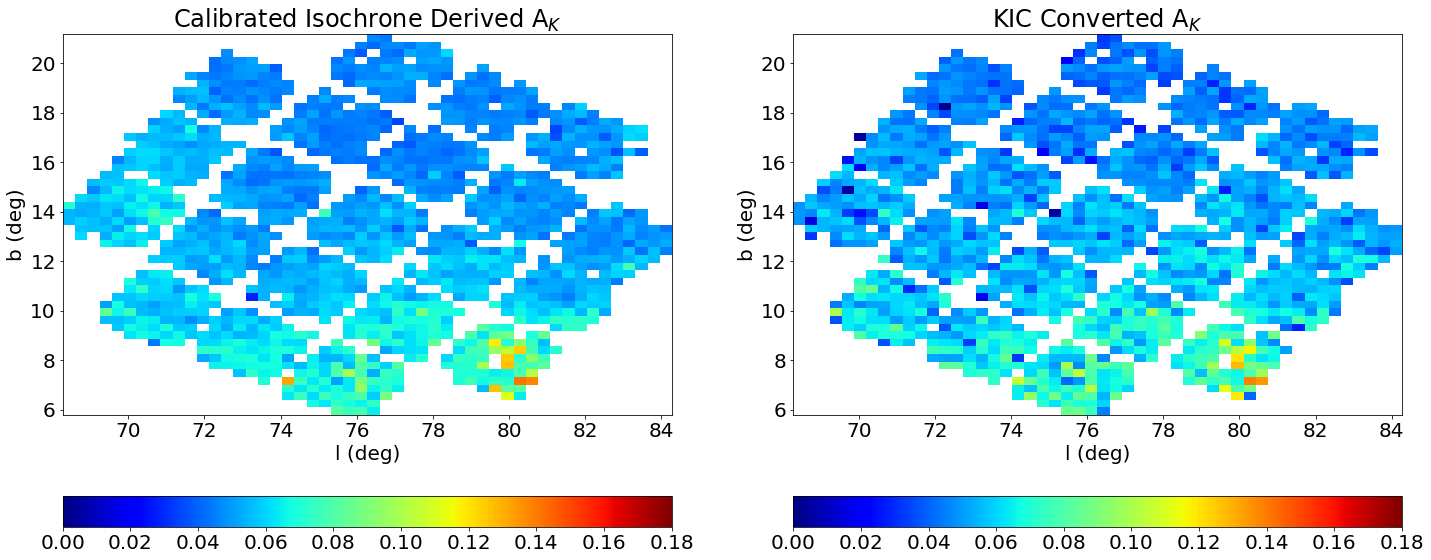

In [35]:
plt.figure(figsize=[24,10])

fincut = np.where((np.isfinite(agetab['AK'])==True)&(np.isfinite(k672dr17['KIC_EBMV'])==True)&
                  (agetab['AK']<10.)&(k672dr17['KIC_EBMV']>-10.))

plt.subplot(121)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],
                          (agetab['AK']+ak_calib(agetab['AK'],*popt_ak_calib))[fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.,vmax=0.180)

plt.colorbar(orientation='horizontal')

plt.title(r'Calibrated Isochrone Derived A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

print('{:.5f}+/-{:.5f}'.format(np.median((agetab['AK']+ak_calib(agetab['AK'],*popt_ak_calib))[fincut]),
                               mad((agetab['AK']+ak_calib(agetab['AK'],*popt_ak_calib))[fincut])))
print(np.mean(agetab['AK'][fincut]))
print('-----')

plt.subplot(122)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],k672dr17['KIC_EBMV'][fincut]*ak_ebv,
                          'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.,vmax=0.180)

plt.colorbar(orientation='horizontal')

plt.title(r'KIC Converted A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

print('{:.5f}+/-{:.5f}'.format(np.median(k672dr17['KIC_EBMV'][fincut]*ak_ebv),
                               mad(k672dr17['KIC_EBMV'][fincut]*ak_ebv)))
print(np.mean(k672dr17['KIC_EBMV'][fincut]*ak_ebv))

plt.savefig('../plots/kasc_cal_ext_map.pdf',dpi=300,bbox_inches='tight')

plt.show()

# Ages

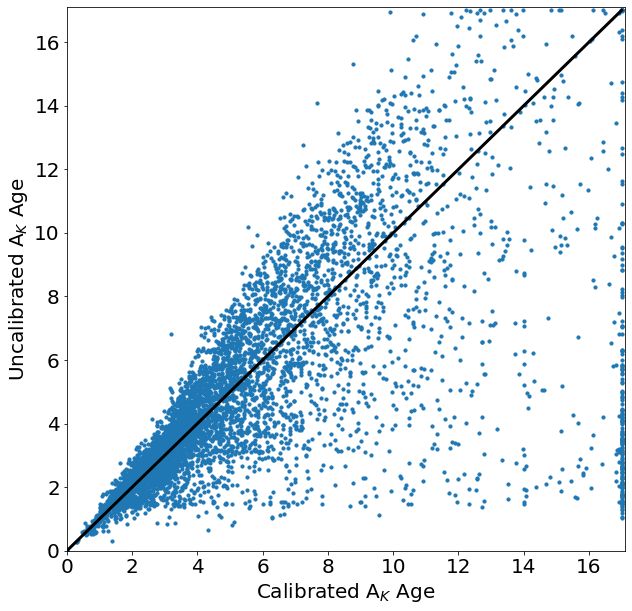

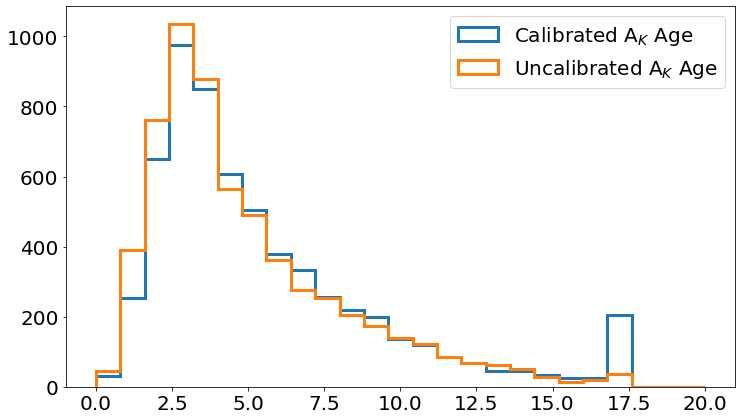

In [54]:
plt.figure(figsize=[10,10])
plt.scatter(agetab['AGE'],agetab_uncal['AGE'],s=10)
plt.plot([0,17],[0,17],c='k',lw=3.0)
plt.xlim(0,17.1)
plt.ylim(0,17.1)

plt.xlabel(r'Calibrated A$_K$ Age')
plt.ylabel(r'Uncalibrated A$_K$ Age')
plt.show()

plt.figure(figsize=[12,7])
plt.hist(agetab['AGE'],histtype='step',lw=3.0,range=(0,20),bins=25,label='Calibrated A$_K$ Age')
plt.hist(agetab_uncal['AGE'],histtype='step',lw=3.0,range=(0,20),bins=25,label='Uncalibrated A$_K$ Age')
plt.legend()
plt.show()

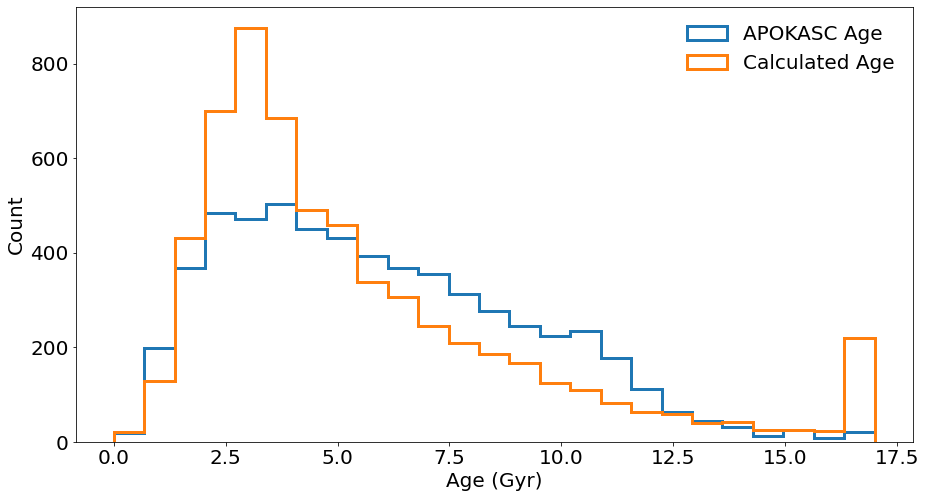

In [36]:
plt.figure(figsize=[15,8])
plt.hist(k3dr17['IntAge'],range=(0,17),bins=25,density=False,histtype='step',lw=3.0,label='APOKASC Age')
plt.hist(agetab['AGE'],range=(0,17),bins=25,density=False,histtype='step',lw=3.0,label='Calculated Age')
plt.legend(frameon=False)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Count')
plt.show()

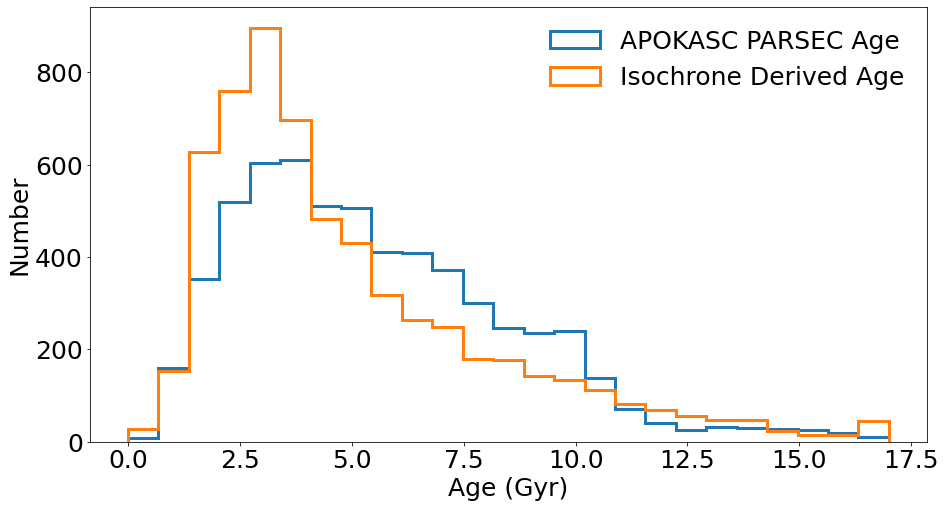

In [37]:
### Age Histogram with APOKASC PARSEC Ages 
plt.figure(figsize=[15,8])
plt.hist(agetab['PARSEC_AGE'],range=(0,17),bins=25,density=False,histtype='step',
         lw=3.0,label='APOKASC PARSEC Age')
plt.hist(agetab['AGE'],range=(0,17),bins=25,density=False,histtype='step',
         lw=3.0,label='Isochrone Derived Age')
plt.legend(frameon=False)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Number')
plt.savefig('../plots/pkasc_age_hist.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [255]:
print('APOKASC {:.2f}+/-{:.2f}'.format(np.nanmedian(agetab['PARSEC_AGE']),mad(agetab['PARSEC_AGE'])))
print('Calculated {:.2f}+/-{:.2f}'.format(np.nanmedian(agetab['AGE']),mad(agetab['AGE'])))

APOKASC 5.12+/-2.12
Calculated 3.93+/-1.63


In [252]:
np.nanmedian(agetab['PARSEC_AGE'])-mad(agetab['PARSEC_AGE'])

2.9953255496014544

In [254]:
np.nanmedian(agetab['AGE'])+mad(agetab['AGE'])

5.560128945638763

In [124]:
agetab.columns

<TableColumns names=('NAME','AGE','AK','PARSEC_AGE','MASS')>

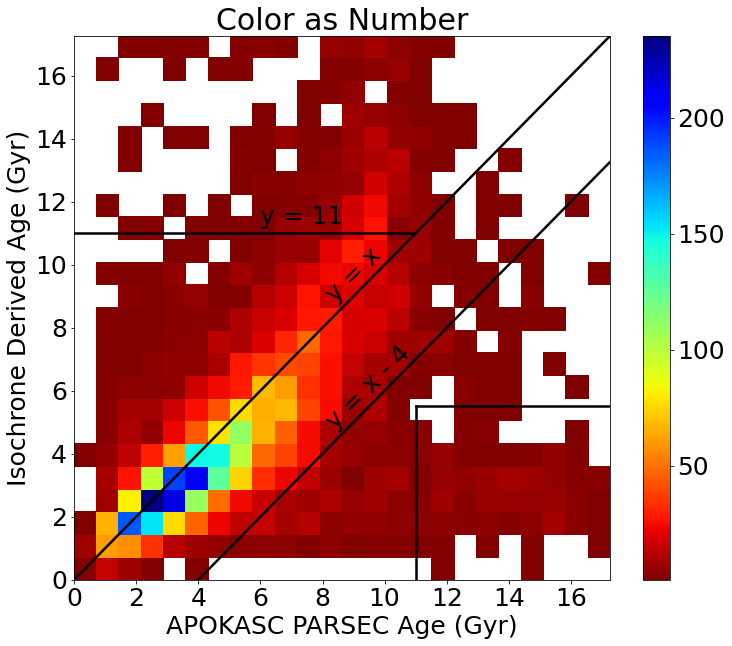

In [38]:
badcut = np.where(agetab['AGE']<999999.0)

xpk = agetab['PARSEC_AGE'][badcut]
ypk = agetab['AGE'][badcut]
xmax = 18
ymax = 18
nbins = 25

plt.figure(figsize=[12,10])
plt.hist2d(xpk,ypk,bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)],cmap='jet_r',cmin=1)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
# plt.text(0.75,11.3,'y = 11')
plt.text(6.,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC PARSEC Age (Gyr)')
plt.ylabel('Isochrone Derived Age (Gyr)')
cbar = plt.colorbar()
# cbar.ax.set_ylabel('Counts')
plt.title(r'Color as Number')
plt.savefig('../plots/pkasc_age_age_count.pdf',dpi=300,bbox_inches='tight')
plt.show()

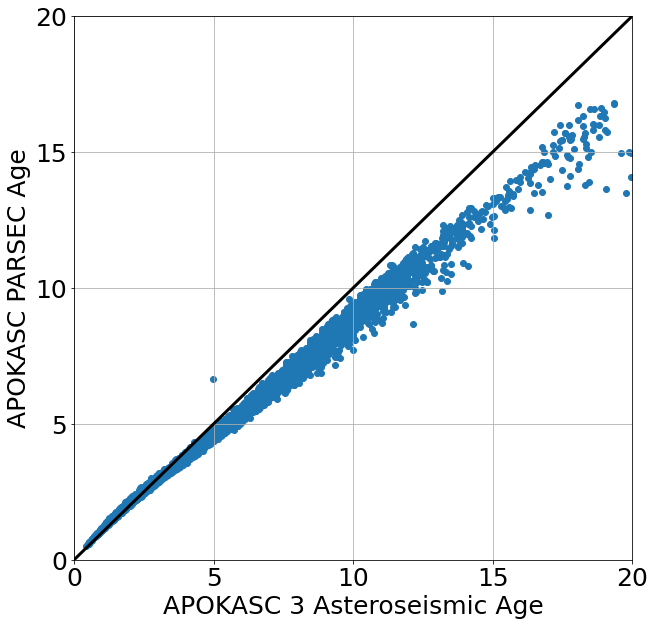

In [133]:
plt.figure(figsize=[10,10])
plt.scatter(k3dr17['IntAge'][badcut],xpk)
plt.plot([0,20],[0,20],c='k',lw=3.0)
plt.xlim(0,20)
plt.ylim(0,20)

plt.xticks(np.arange(21)[::5])
plt.yticks(np.arange(21)[::5])
plt.grid()

plt.xlabel(r'APOKASC 3 Asteroseismic Age')
plt.ylabel(r'APOKASC PARSEC Age')

plt.savefig('../plots/kasc_astero_parsec.pdf',dpi=300,bbox_inches='tight')
plt.show()

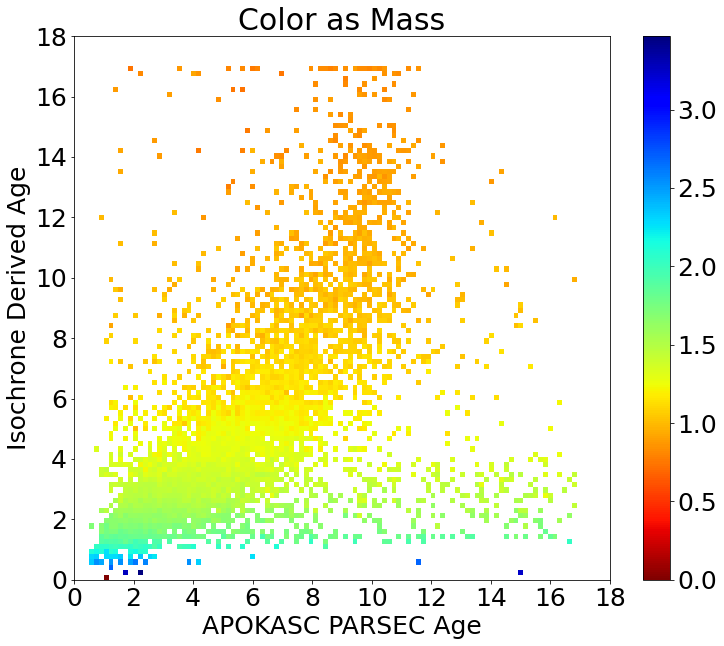

In [116]:
fincut = np.where((np.isfinite(ypk)==True)&(np.isfinite(xpk)==True)&
                  (xpk>-20.)&(xpk<20.)&(ypk<20.)&(ypk>-20.)&(agetab['MASS'][badcut]<100.))

ret = binned_statistic_2d(xpk[fincut],ypk[fincut],agetab['MASS'][badcut][fincut],'median',bins=100)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])

plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
       aspect='auto',interpolation='nearest',cmap='jet_r',vmin=0.)
plt.colorbar()

plt.xticks(np.arange(20)[::2])
plt.yticks(np.arange(20)[::2])

plt.title(r'Color as Mass')
plt.xlabel(r'APOKASC PARSEC Age')
plt.ylabel(r'Isochrone Derived Age')

# plt.savefig('../plots/mass_massresid_feh_fullfehA.pdf',bbox_inches='tight')
plt.show()

Fit Parameters:
a = -0.04810
b = 0.31530
c = 0.43006


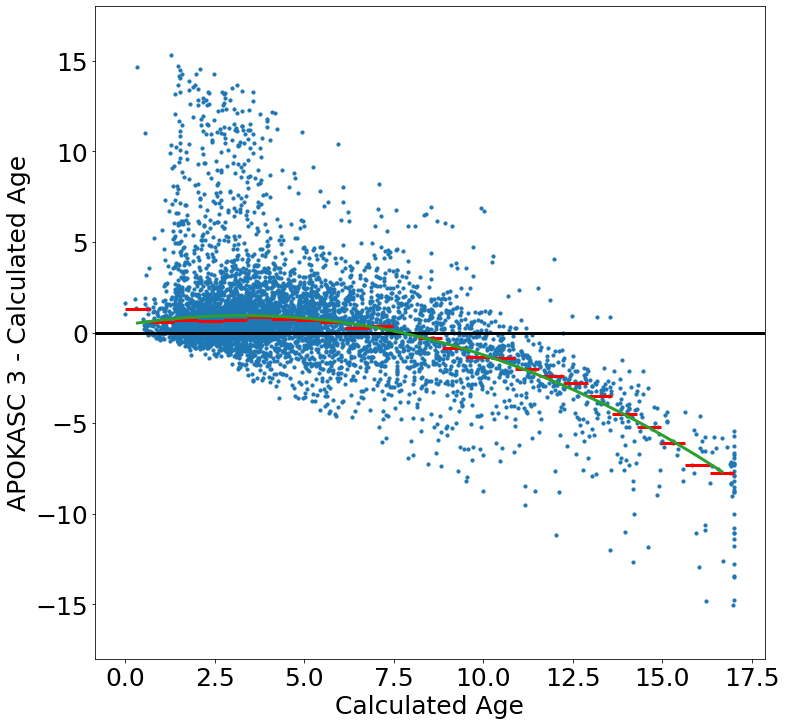

0.588 +/- 0.886


In [22]:
from scipy.optimize import curve_fit

fincut = np.where((np.isfinite(ypk)==True)&(np.isfinite(xpk)==True)&
                  (xpk>-20.)&(ypk>-20.))

bin_medians,bin_edges,_ = binned_statistic(ypk[fincut],(xpk-ypk)[fincut],statistic='median',bins=25)
bin_centers = (bin_edges[:-1]+np.diff(bin_edges)/2)

# def dage_age(x,a,b,age0,dage0):
#     return np.piecewise(x,[x<age0],[lambda x: dage0, 
#                                     lambda x: a*(x**2-age0**2)+b*(x-age0)+age0])

def dage_age(x,a,b,c):
    return a*x**2+b*x+c

bincut = np.where((np.isfinite(bin_medians)==True)&(np.isfinite(bin_centers)==True))

param_labels = np.array(['a','b','c'])
popt_dage, _ = curve_fit(dage_age, bin_centers[bincut], bin_medians[bincut], p0 = [1,1,1])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_dage[i]))

plt.figure(figsize=[12,12])
plt.scatter(ypk,xpk-ypk,s=10)
plt.axhline(0.0,c='k',lw=3.0)
# plt.axvline(8.5,c='r',lw=3.0)
plt.hlines(bin_medians,bin_edges[:-1],bin_edges[1:],colors='r',lw=3.)

ages_xs = np.linspace(0,17)
plt.plot(bin_centers[bincut],dage_age(bin_centers[bincut],*popt_dage),c='tab:green',lw=3.)

plt.ylim(-18,18)
plt.xlabel(r'Calculated Age')
plt.ylabel(r'APOKASC 3 - Calculated Age')
plt.show()

# print('{:.3f} +/- {:.3f}'.format(np.nanmedian((xpk-ypk)[np.where(ypk<8.5)]),mad((xpk-ypk)[np.where(ypk<8.5)])))
print('{:.3f} +/- {:.3f}'.format(np.nanmedian((xpk-ypk)[np.where(ypk<10)]),mad((xpk-ypk)[np.where(ypk<10)])))

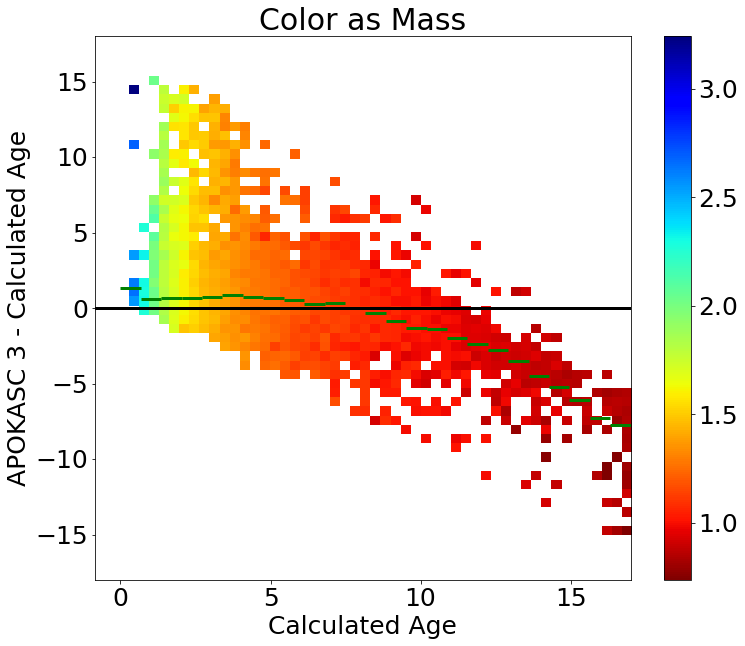

In [125]:
fincut = np.where((np.isfinite(ypk)==True)&(np.isfinite(xpk)==True)&
                  (xpk>-20.)&(xpk<20.)&(ypk<20.)&(ypk>-20.)&
                  (agetab['MASS'][badcut]<100.)&(agetab['MASS'][badcut]>0))

ret = binned_statistic_2d(ypk[fincut],(xpk-ypk)[fincut],agetab['MASS'][badcut][fincut],'median',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])

plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
       aspect='auto',interpolation='nearest',cmap='jet_r')
plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)
plt.hlines(bin_medians,bin_edges[:-1],bin_edges[1:],colors='g',lw=3.)

# plt.plot(bin_centers[bincut],dage_age(bin_centers[bincut],*popt_dage),c='tab:green',lw=3.)

plt.ylim(-18,18)
plt.title(r'Color as Mass')
plt.xlabel(r'Calculated Age')
plt.ylabel(r'APOKASC 3 - Calculated Age')
plt.show()

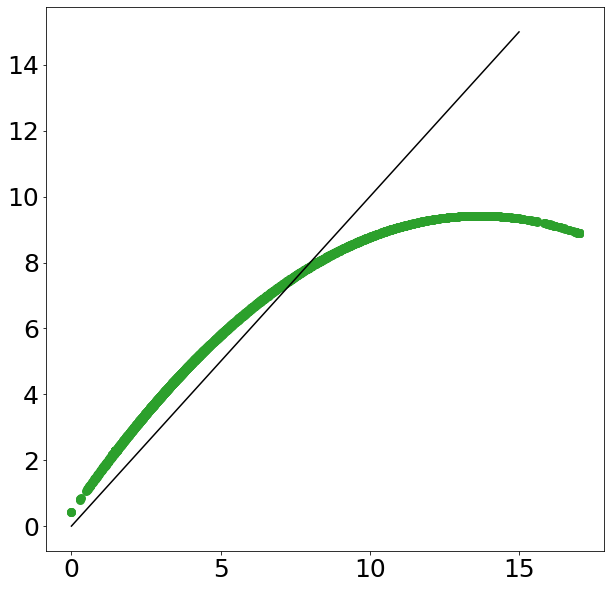

In [57]:
plt.figure(figsize=[10,10])
plt.scatter(ypk,ypk+dage_age(ypk,*popt_dage),c='tab:green',lw=3.)
plt.plot([0,15],[0,15],c='k')

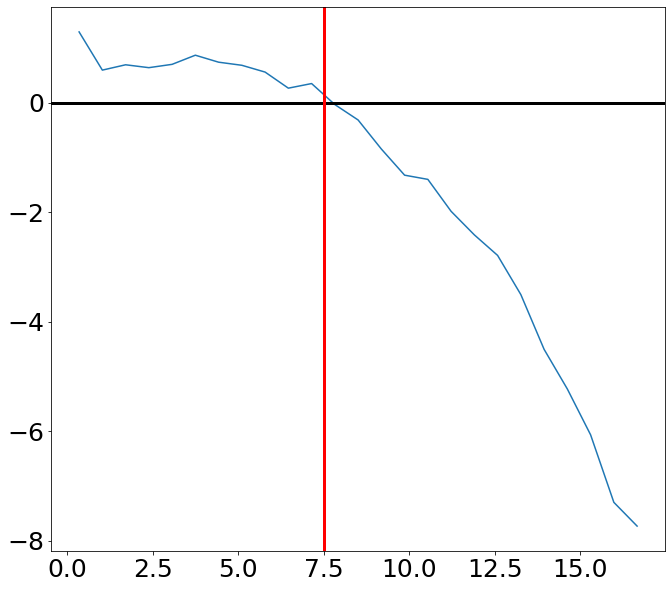

In [23]:
plt.figure(figsize=[11,10])
plt.plot(bin_centers,bin_medians)
plt.axhline(0.,c='k',lw=3.0)
# plt.axvline(9.426613548049032,c='r',lw=3.0)
plt.axvline(7.5,c='r',lw=3.0)

In [24]:
def dage_pre75(x,a):
    return a

bincutpre75 = np.where((np.isfinite(bin_medians)==True)&(np.isfinite(bin_centers)==True)&(bin_centers<7.5))

param_labels = np.array(['a'])
popt_dage_pre75, _ = curve_fit(dage_pre75,bin_centers[bincutpre75],bin_medians[bincutpre75],p0=[0.5])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_dage_pre75[i]))
    

Fit Parameters:
a = 0.67374


In [103]:
def dage_pre10(x,a):
    return a#+b*x#+c*x**2

bincutpre10 = np.where((np.isfinite(bin_medians)==True)&(np.isfinite(bin_centers)==True)&(bin_centers<10))

param_labels = np.array(['a'])#,'b'])#,'c'])
popt_dage_pre10, _ = curve_fit(dage_pre10,bin_centers[bincutpre10],bin_medians[bincutpre10],p0=[0.5])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_dage_pre10[i]))
    
def dage_pre10b(x,a):
    x = np.asarray(x)
    rets = 999999.0*np.ones(len(x))
    for i in range(len(x)):
        rets[i] = a 
    return rets

Fit Parameters:
a = 0.32648


In [25]:
def dage_post75(x,a,b):
    return a*x+b

bincutpost75 = np.where((np.isfinite(bin_medians)==True)&(np.isfinite(bin_centers)==True)&(bin_centers>=7.5))

param_labels = np.array(['a','b'])
popt_dage_post75, _ = curve_fit(dage_post75,bin_centers[bincutpost75],bin_medians[bincutpost75],p0=[0.5,7.5])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_dage_post75[i]))

Fit Parameters:
a = -0.87870
b = 7.50890


In [61]:
def dage_post10(x,a,b):
    return a*x+b

bincutpost10 = np.where((np.isfinite(bin_medians)==True)&(np.isfinite(bin_centers)==True)&(bin_centers>=10.))

param_labels = np.array(['a','b'])
popt_dage_post10, _ = curve_fit(dage_post10,bin_centers[bincutpost10],bin_medians[bincutpost10],p0=[0.5,7.5])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_dage_post10[i]))

Fit Parameters:
a = -1.07723
b = 10.35665


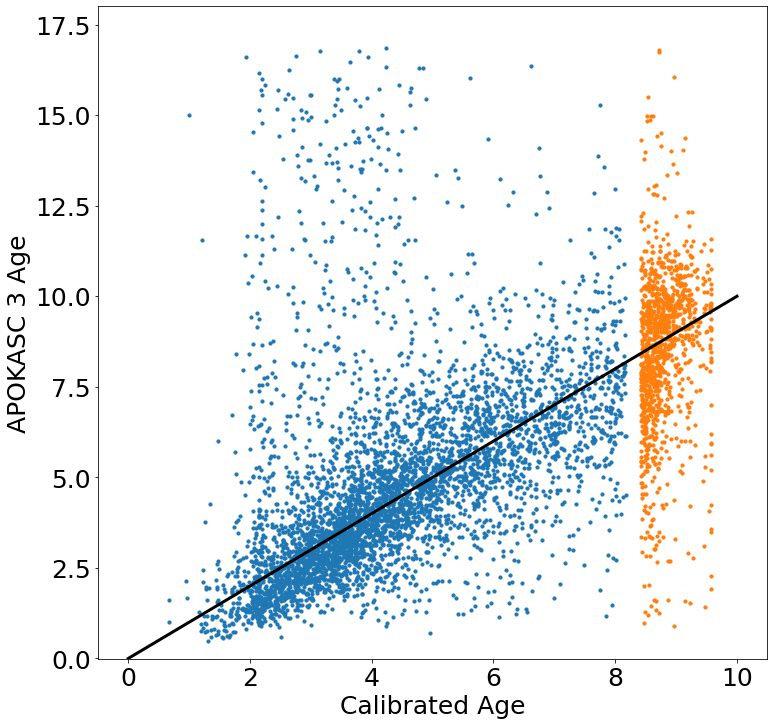

In [26]:
plt.figure(figsize=[12,12])

calc_pre75 = np.where(ypk<7.5)
calc_post75 = np.where(ypk>=7.5)

plt.scatter(ypk[calc_pre75]+dage_pre75(ypk[calc_pre75],*popt_dage_pre75),xpk[calc_pre75],s=10)
plt.scatter(ypk[calc_post75]+dage_post75(ypk[calc_post75],*popt_dage_post75),xpk[calc_post75],s=10)

plt.plot([0,10],[0,10],c='k',lw=3.0)

plt.ylim(-0.01,18)
plt.xlabel(r'Calibrated Age')
plt.ylabel(r'APOKASC 3 Age')
plt.show()

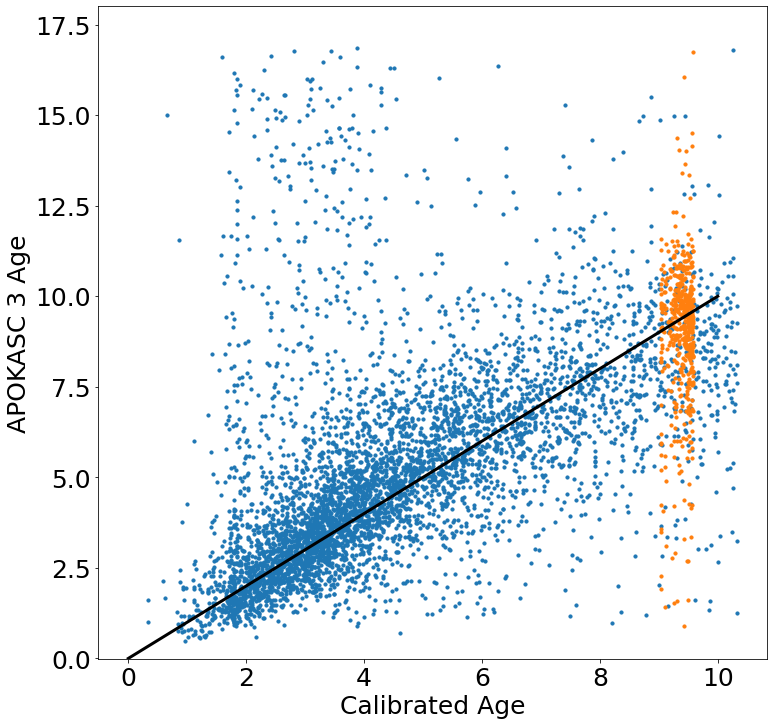

In [76]:
plt.figure(figsize=[12,12])

calc_pre10 = np.where(ypk<10)
calc_post10 = np.where(ypk>=10)

plt.scatter(ypk[calc_pre10]+dage_pre10(ypk[calc_pre10],*popt_dage_pre10),xpk[calc_pre10],s=10)
plt.scatter(ypk[calc_post10]+dage_post10(ypk[calc_post10],*popt_dage_post10),xpk[calc_post10],s=10)

plt.plot([0,10],[0,10],c='k',lw=3.0)

plt.ylim(-0.01,18)
plt.xlabel(r'Calibrated Age')
plt.ylabel(r'APOKASC 3 Age')
plt.show()

In [98]:
def test(x,a):
    x = np.asarray(x)
    rets = 999999.0*np.ones(len(x))
    for i in x:
        rets[i] = a 
    return rets

test(np.arange(10),0.5)

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

<function dage_pre10 at 0x7f9402043040>


In [106]:
dage_pre10b(bin_centers[bincutpre10],*popt_dage_pre10)

array([0.32647776, 0.32647776, 0.32647776, 0.32647776, 0.32647776,
       0.32647776, 0.32647776, 0.32647776, 0.32647776, 0.32647776,
       0.32647776, 0.32647776, 0.32647776, 0.32647776, 0.32647776])

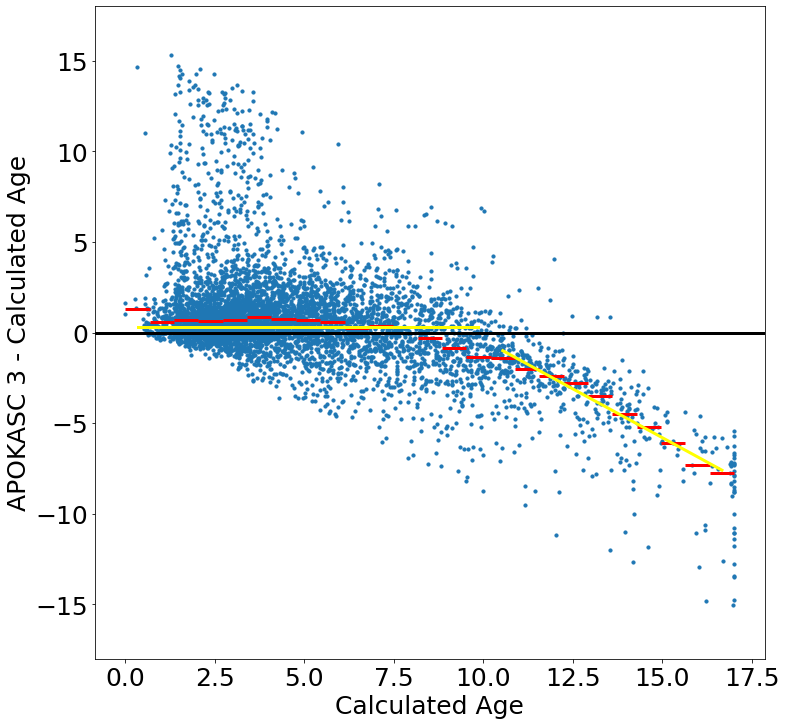

In [107]:
plt.figure(figsize=[12,12])
plt.scatter(ypk,xpk-ypk,s=10)
plt.axhline(0.0,c='k',lw=3.0)
plt.hlines(bin_medians,bin_edges[:-1],bin_edges[1:],colors='r',lw=3.)

plt.plot(bin_centers[bincutpre10],dage_pre10b(bin_centers[bincutpre10],*popt_dage_pre10),c='yellow',lw=3.)
plt.plot(bin_centers[bincutpost10],dage_post10(bin_centers[bincutpost10],*popt_dage_post10),c='yellow',lw=3.)

plt.ylim(-18,18)
plt.xlabel(r'Calculated Age')
plt.ylabel(r'APOKASC 3 - Calculated Age')
plt.show()

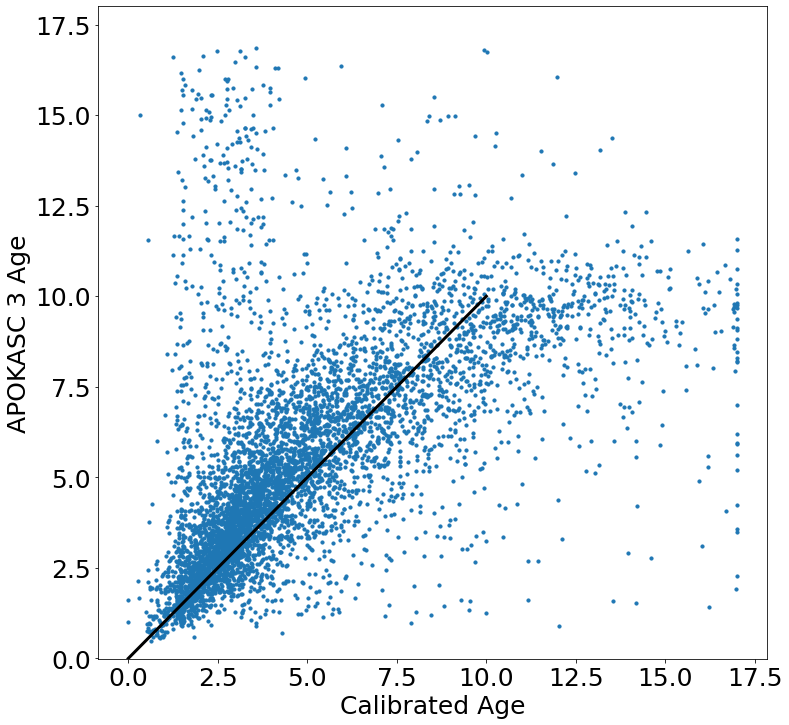

In [108]:
plt.figure(figsize=[12,12])

plt.scatter(ypk,xpk,s=10)

plt.plot([0,10],[0,10],c='k',lw=3.0)

plt.ylim(-0.01,18)
plt.xlabel(r'Calibrated Age')
plt.ylabel(r'APOKASC 3 Age')
plt.show()

In [27]:
max(ypk[calc_post75]+dage_post75(ypk[calc_post75],*popt_dage_post75))

9.570939227179608

In [28]:
def dage_line(x,a,b):
    return a*x+b

bincut = np.where((np.isfinite(bin_medians)==True)&(np.isfinite(bin_centers)==True))

param_labels = np.array(['a','b'])
popt_dage_line, _ = curve_fit(dage_line,bin_centers[bincut],bin_medians[bincut],p0=[0.5,7.5])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_dage_line[i]))

Fit Parameters:
a = -0.50238
b = 2.74865


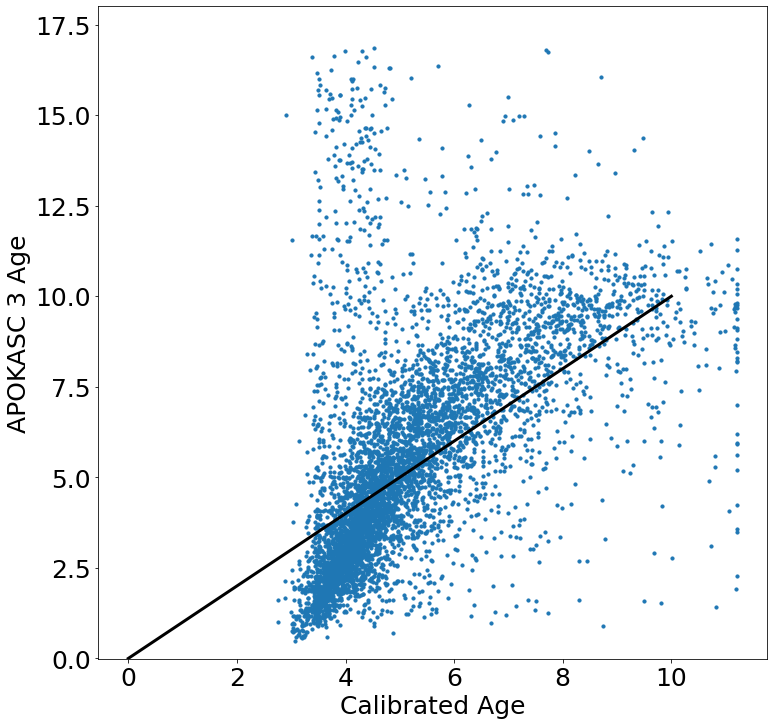

In [29]:
plt.figure(figsize=[12,12])

plt.scatter(ypk+dage_line(ypk,*popt_dage_line),xpk,s=10)

plt.plot([0,10],[0,10],c='k',lw=3.0)

plt.ylim(-0.01,18)
plt.xlabel(r'Calibrated Age')
plt.ylabel(r'APOKASC 3 Age')
plt.show()

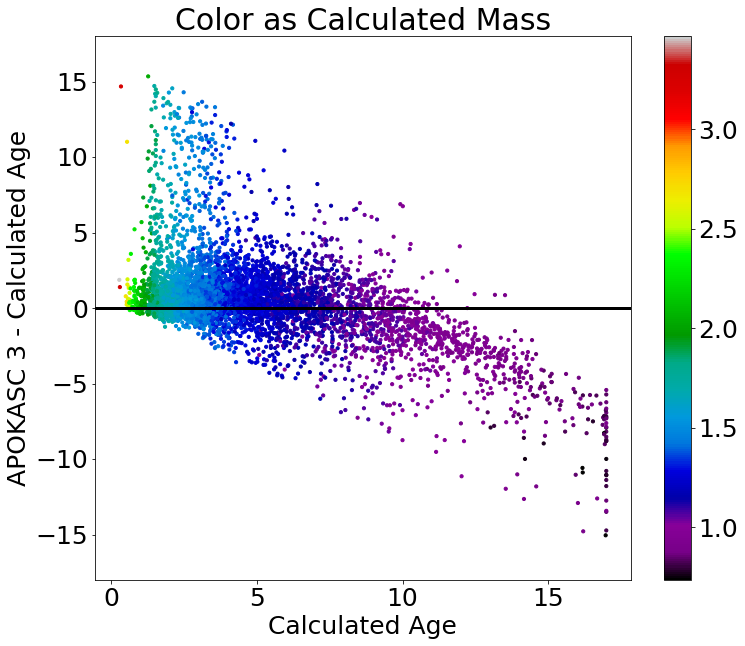

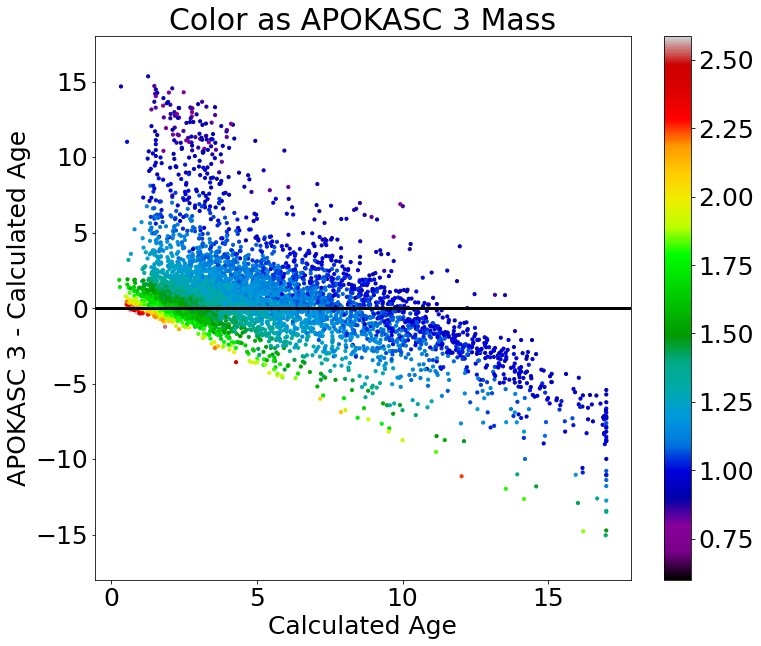

In [31]:
goodmass = np.where((agetab['MASS'][badcut]>0.)&(agetab['MASS'][badcut]<10.))
plt.figure(figsize=[12,10])
plt.scatter(ypk[goodmass],(xpk-ypk)[goodmass],c=agetab['MASS'][badcut][goodmass],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-18,18)
plt.title(r'Color as Calculated Mass')
plt.xlabel(r'Calculated Age')
plt.ylabel(r'APOKASC 3 - Calculated Age')
plt.show()

goodmass = np.where((agetab['MASS'][badcut]>0.)&(agetab['MASS'][badcut]<10.))
plt.figure(figsize=[12,10])
plt.scatter(ypk[goodmass],(xpk-ypk)[goodmass],c=k3dr17['Mass'][badcut][goodmass],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-18,18)
plt.title(r'Color as APOKASC 3 Mass')
plt.xlabel(r'Calculated Age')
plt.ylabel(r'APOKASC 3 - Calculated Age')
plt.show()

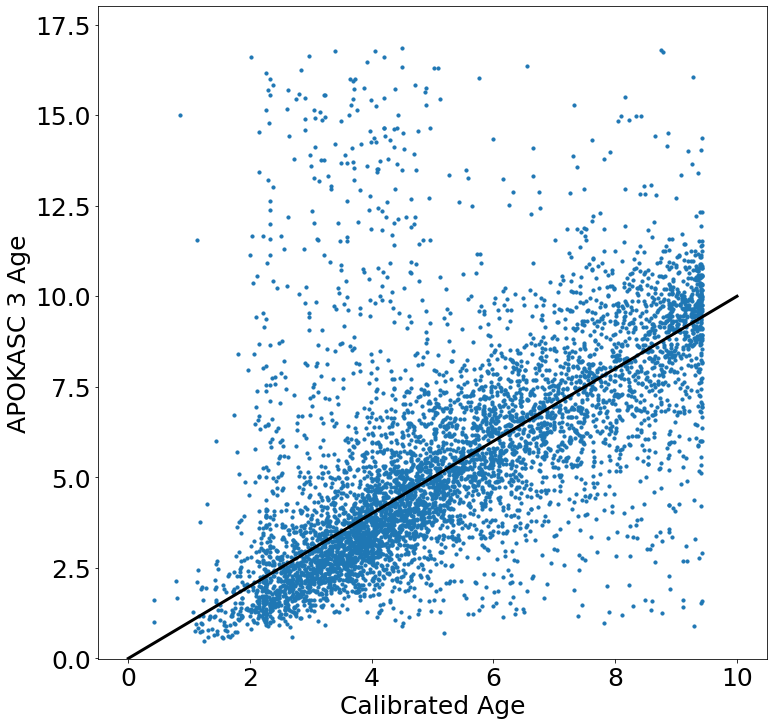

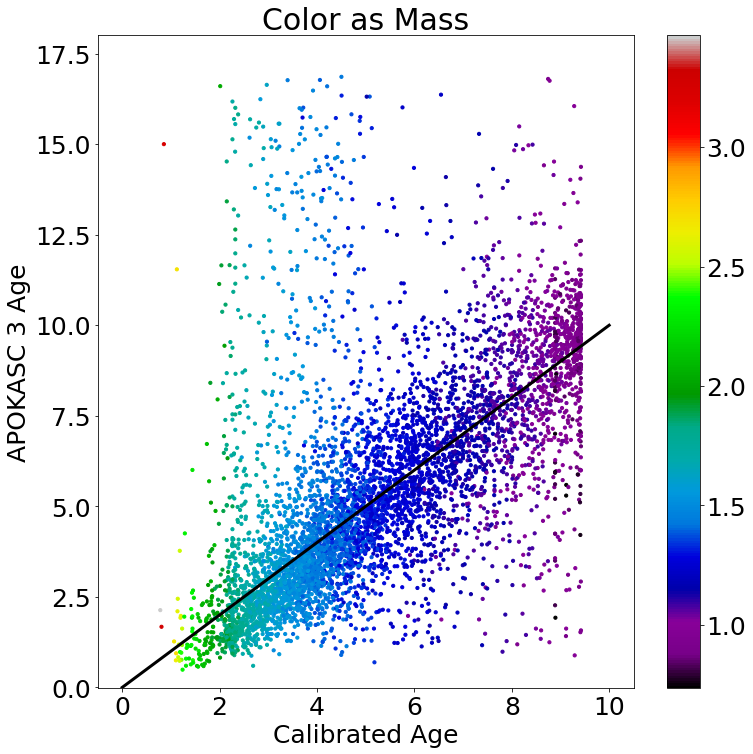

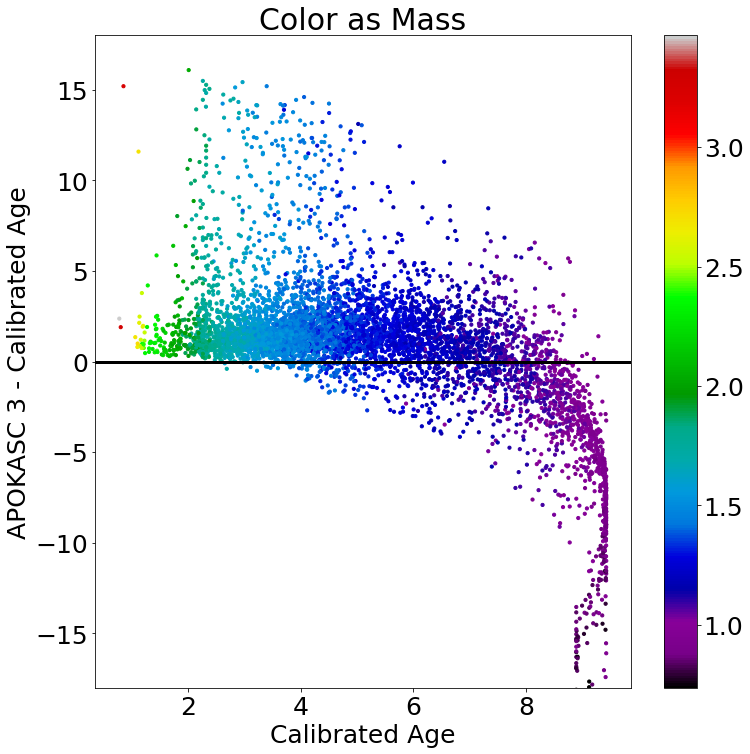

In [35]:
plt.figure(figsize=[12,12])
# plt.scatter(ypk,xpk-ypk,s=10)
# plt.axhline(0.0,c='k',lw=3.0)

ages_xs = np.linspace(0,17)
plt.scatter(ypk+dage_age(ypk,*popt_dage),xpk,s=10)

plt.plot([0,10],[0,10],c='k',lw=3.0)

plt.ylim(-0.01,18)
plt.xlabel(r'Calibrated Age')
plt.ylabel(r'APOKASC 3 Age')
plt.show()

max(ypk+dage_age(ypk,*popt_dage))

plt.figure(figsize=[12,12])

ages_xs = np.linspace(0,17)
plt.scatter((ypk+dage_age(ypk,*popt_dage))[goodmass],xpk[goodmass],
            c=agetab['MASS'][badcut][goodmass],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.plot([0,10],[0,10],c='k',lw=3.0)
# plt.axhline(0,c='k',lw=3.)

plt.ylim(-0.01,18)
plt.title(r'Color as Mass')
plt.xlabel(r'Calibrated Age')
plt.ylabel(r'APOKASC 3 Age')
plt.show()

###
plt.figure(figsize=[12,12])

ages_xs = np.linspace(0,17)
plt.scatter((ypk+dage_age(ypk,*popt_dage))[goodmass],(xpk-ypk+dage_age(ypk,*popt_dage))[goodmass],
            c=agetab['MASS'][badcut][goodmass],cmap='nipy_spectral',s=10)

plt.colorbar()
# plt.plot([0,10],[0,10],c='k',lw=3.0)
plt.axhline(0,c='k',lw=3.)
plt.ylim(-18,18)
plt.title(r'Color as Mass')
plt.xlabel(r'Calibrated Age')
plt.ylabel(r'APOKASC 3 - Calibrated Age')
plt.show()

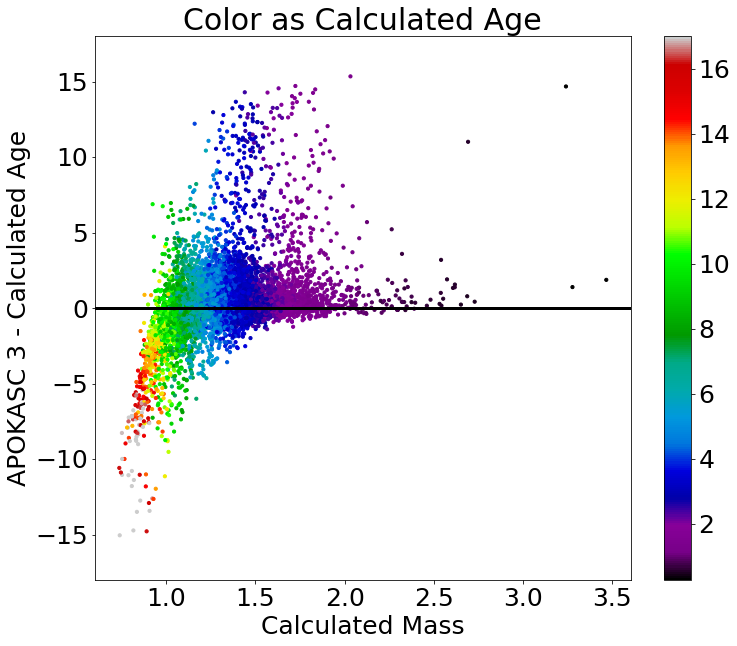

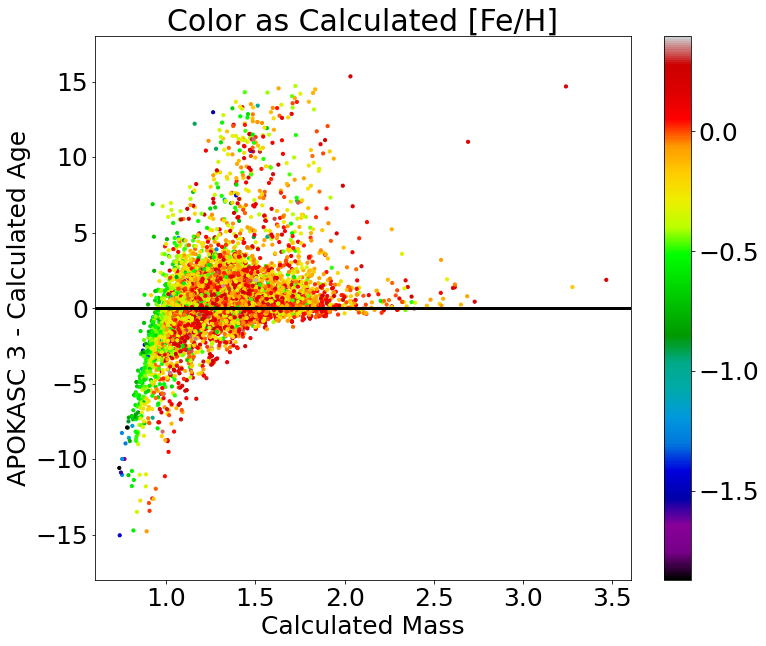

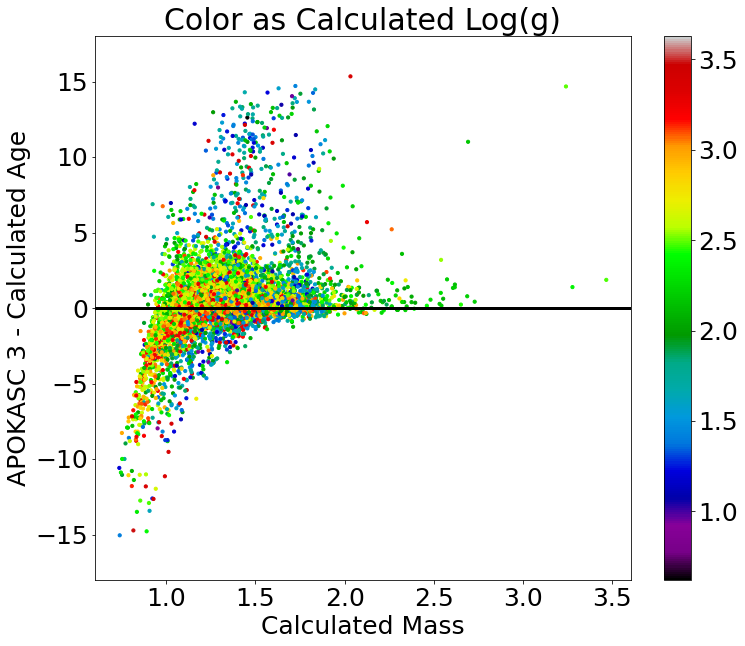

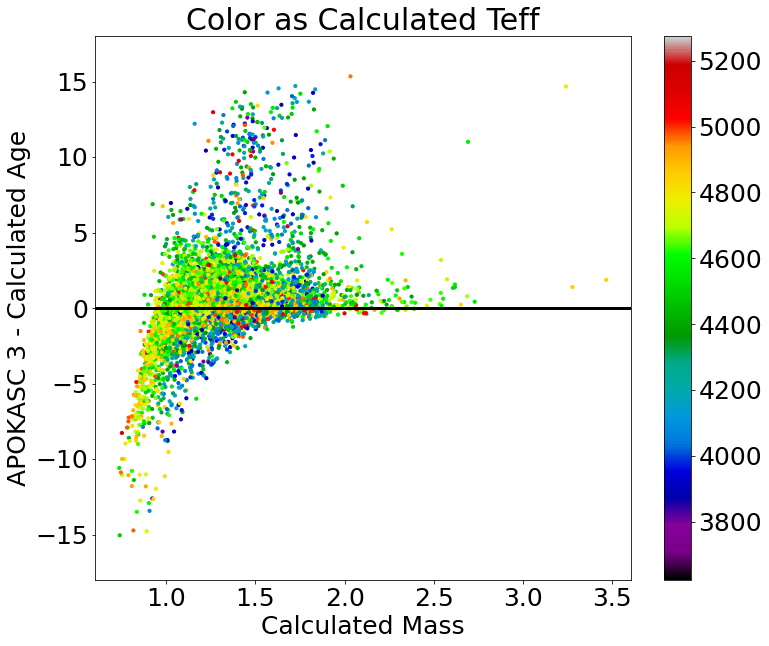

In [32]:
plt.figure(figsize=[12,10])
plt.scatter(agetab['MASS'][badcut][goodmass],(xpk-ypk)[goodmass],
            c=ypk[goodmass],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-18,18)
plt.title(r'Color as Calculated Age')
plt.xlabel(r'Calculated Mass')
plt.ylabel(r'APOKASC 3 - Calculated Age')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(agetab['MASS'][badcut][goodmass],(xpk-ypk)[goodmass],
            c=kdr17['FE_H'][badcut][goodmass],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-18,18)
plt.title(r'Color as Calculated [Fe/H]')
plt.xlabel(r'Calculated Mass')
plt.ylabel(r'APOKASC 3 - Calculated Age')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(agetab['MASS'][badcut][goodmass],(xpk-ypk)[goodmass],
            c=kdr17['LOGG'][badcut][goodmass],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-18,18)
plt.title(r'Color as Calculated Log(g)')
plt.xlabel(r'Calculated Mass')
plt.ylabel(r'APOKASC 3 - Calculated Age')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(agetab['MASS'][badcut][goodmass],(xpk-ypk)[goodmass],
            c=kdr17['TEFF'][badcut][goodmass],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-18,18)
plt.title(r'Color as Calculated Teff')
plt.xlabel(r'Calculated Mass')
plt.ylabel(r'APOKASC 3 - Calculated Age')
plt.show()

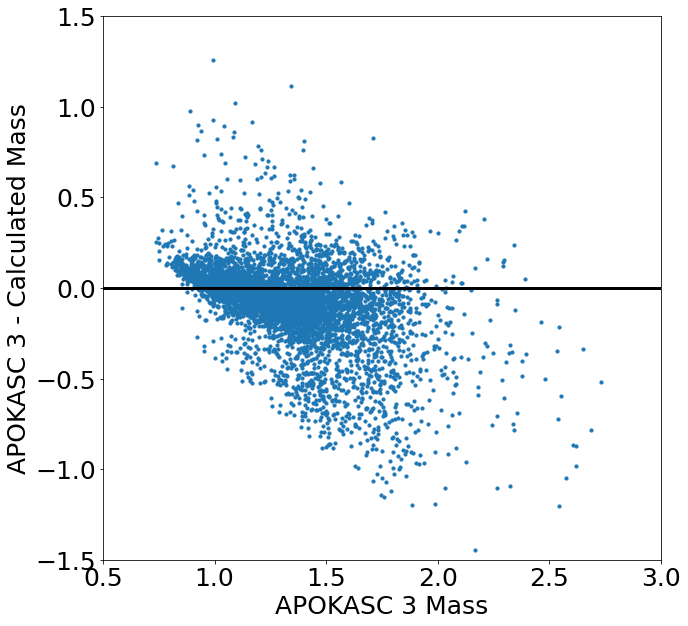

In [34]:
# from scipy.stats import binned_statistic

# fincut = np.where((np.isfinite(agetab['MASS'])==True)&(np.isfinite(k3dr17['Mass'])==True)&
#                   (agetab['MASS']<20.)&(k3dr17['Mass']>-20.))

# bin_medians,bin_edges,_ = binned_statistic(agetab['MASS'][fincut],(k3dr17['Mass']-agetab['MASS'])[fincut],
#                                            statistic='median',bins=150)
# bin_width = (bin_edges[1] - bin_edges[0])
# bin_centers = bin_edges[1:] - bin_width/2

plt.figure(figsize=[10,10])
plt.scatter(agetab['MASS'],k3dr17['Mass']-agetab['MASS'],s=10)

# plt.hlines(bin_medians,bin_edges[:-1],bin_edges[1:],colors='r',lw=2)

# plt.plot([0,4],[0,4],c='k')
plt.axhline(0.0,c='k',lw=3.0)

plt.xlim(0.5,3)
plt.ylim(-1.5,1.5)

# plt.yticks(np.arange(5))
# plt.xticks(np.arange(5))

plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'APOKASC 3 - Calculated Mass')

plt.show()

# Masses

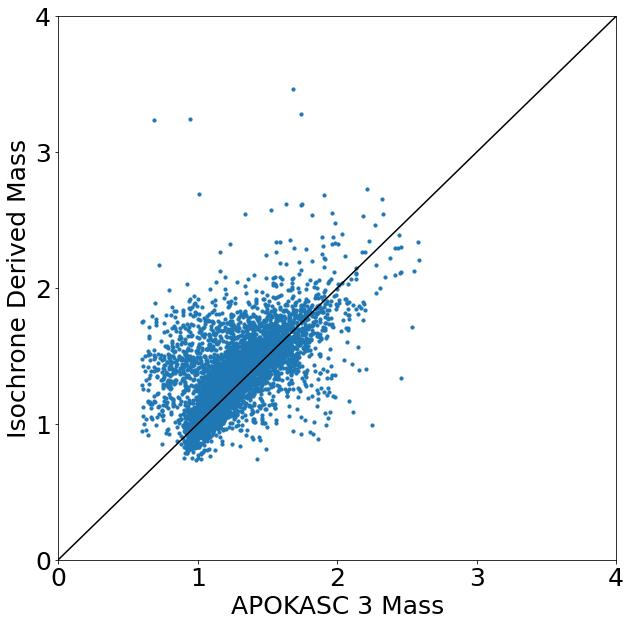

In [134]:
plt.figure(figsize=[10,10])
plt.scatter(k3dr17['Mass'],agetab['MASS'],s=10)
plt.plot([0,4],[0,4],c='k')
plt.xlim(0,4)
plt.ylim(0,4)

plt.yticks(np.arange(5))
plt.xticks(np.arange(5))

plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'Isochrone Derived Mass')

plt.show()

In [ ]:
fincut = np.where((np.isfinite(ypk)==True)&(np.isfinite(xpk)==True)&
                  (xpk>-20.)&(xpk<20.)&(ypk<20.)&(ypk>-20.)&
                  (agetab['MASS'][badcut]<100.)&(agetab['MASS'][badcut]>0))

plt.figure(figsize=[10,10])
plt.scatter(k3dr17['Mass'],agetab['MASS'],s=10)
plt.plot([0,4],[0,4],c='k')
plt.xlim(0,4)
plt.ylim(0,4)

plt.yticks(np.arange(5))
plt.xticks(np.arange(5))

plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'Isochrone Derived Mass')

plt.show()

In [ ]:


ret = binned_statistic_2d(ypk[fincut],(xpk-ypk)[fincut],agetab['MASS'][badcut][fincut],'median',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])

plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
       aspect='aut